In [5]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# Enriching (extra)
import tmdbsimple as tmdb # Wrapper library for the API of themoviedb.org  (TMDB)
from tqdm import tqdm # Progress bar for the script
from datetime import datetime # Used for dates 
from dotenv import load_dotenv # Makes keeping the API-key as local environment file simpler
import os # Used for loading the .env file

# Linear models
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import ast # used for converting string lists to lists with string elements

# NLP (extra)
import re
import json
import nltk
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



# Enriching data
## Adding data from www.themoviedb.org (TMDB)


In this section we are going to be using the API of www.themoviedb.org (TMDB) to populate the existing dataframe with more information about the movie. The script (TMDB_v1) will query the website using the movie name to find the closest match based on the movie's release date. If no match is found, it skips the movie and moves on to the next one.

This 1. step is adding a lot of different data from TMDB. The most important features are the:
- TMDB ID           (unique identifier for the movie, which can be used to further enrich the data)
- TMDB vote average (average movie rating)
- TMDB vote count   (how many votes were cast)

Furthermore, TMDB_v1 also adds the:
- original language, original title, release date, title
- overview (summary)
- popularity (metric composed of many different variables indicating a movies lifetime popularity)


This script was run separately in another file in /utils/add_TMDB_movie_metadata_v1.py as it needed to be executed in  several installments over several sessions, since the API was limited by 40 requests/second. (this version contains slightly different path variations).earlear

In [2]:
load_dotenv() # Loads .env files aka. the TMDB_API_KEY

headers_movie_metadata = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name", "Movie release date",
                          "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries",
                          "Movie genres"]
movie_metadata = pd.read_csv('data/movie.metadata.tsv', sep="\t", names=headers_movie_metadata)


# Load API key
TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  # Seconds, for both connect and read

# Create a list to save progress
saved_progress = []

# Determine where to resume
start_index = 28000

# Progress file that can be used to resume
#saved_progress = pd.read_json('progress.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

# Create a DataFrame to store the data
movie_metadata_TMDB = movie_metadata.copy()

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): # Wraps for loop in progress bar.
    
    # Skip previously processed indices - Commented out in favor of manual start_index
    #if index in saved_progress:
    #    continue
    if index < start_index:
        continue
    try:
        if not pd.isna(row["Movie release date"]):
            search = tmdb.Search()
            response = search.movie(query=row["Movie name"])

            # Convert dataframe release date to datetime
            movie_release_date_str = row["Movie release date"]
            if len(movie_release_date_str) == 4:  # Handle "YYYY" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y").date()
            elif len(movie_release_date_str) == 7:  # Handle "YYYY-DD" format
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m").date()
            else:  # Assume it's in the format "YYYY-MM-DD"
                movie_release_date = datetime.strptime(movie_release_date_str, "%Y-%m-%d").date()

            # Handle if release_date is empty.
            date_list_converted = [datetime.strptime(each_date['release_date'], "%Y-%m-%d").date() for each_date in
                                   search.results if each_date.get('release_date')]

            # Create list of differences in time
            differences = [abs(movie_release_date - each_date) for each_date in date_list_converted]
            
            # If differences are empty = skip
            if not differences:
                continue
            minimum_index = differences.index(min(differences))  # Index of the closest match
            match = search.results[minimum_index]
            # print(f"Closest match: {match['title']} (Release Date: {match['release_date']})")

            # Add info in dataframe about the movie
            movie_metadata_TMDB.loc[index, 'TMDB_id'] = match['id']
            movie_metadata_TMDB.loc[index, 'TMDB_original_language'] = match['original_language']
            movie_metadata_TMDB.loc[index, 'TMDB_original_title'] = match['original_title']
            movie_metadata_TMDB.loc[index, 'TMDB_overview'] = match['overview']
            movie_metadata_TMDB.loc[index, 'TMDB_popularity'] = match['popularity']
            movie_metadata_TMDB.loc[index, 'TMDB_release_date'] = match['release_date']
            movie_metadata_TMDB.loc[index, 'TMDB_title'] = match['title']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_average'] = match['vote_average']
            movie_metadata_TMDB.loc[index, 'TMDB_vote_count'] = match['vote_count']
            
            # Save the index as progress
            saved_progress.append(index)

            # Save progress periodically (in case of interruption)
            if index % 50 == 0:
                progress_df = pd.DataFrame({'index': saved_progress})
                progress_df.to_json('progress.json')
                movie_metadata_TMDB.to_csv('movie_metadata_TMDB.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

# Save final progress
progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress.json')

# Save your final DataFrame
#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB.csv') # Commented out to not overwrite existing file with blank data

Processing: 100%|██████████| 81741/81741 [00:03<00:00, 20657.45it/s]


We are now going to see how many rows of data were populated in the enriching. 
The TMDB_ID is a good indicator for this.

In [3]:
df = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
print(f"Added TMDB ID to {df['TMDB_id'].count()} movies. Total movies: {df['Wikipedia Movie ID'].count()}. \n Percentage populated: {round(df['TMDB_id'].count()/df['Wikipedia Movie ID'].count()*100,2)}%")


Added TMDB ID to 68944 movies. Total movies: 81741. 
 Percentage populated: 84.34%


## Adding Movie Revenue
The script above (TMDB_v1) used a 'query' method for TMDB, we are now going to be using the 'Movies' method to collect further data about the movies (TMDB_v2). 
Since many of the movies are missing their revenue, TMDB might have that information for some movies.

The same basis as for TMDB_v1 is used to collect data. The data being collected is: 
- revenue, budget, runtime, IMDB-id and genres.

While our original dataset includes movie genres, it's always good to have more information and the two might differ for an interesting analysis further on.

Like TMDB_v1, TMDB_v2 was run separately in another file: /utils/add_TMDB_movie_metadata_V2.py as it needed to be run on several occasions since the API is limited.

In [ ]:
load_dotenv()

# Load v1, which was created in TMDB_v1 above
movie_metadata_TMDB = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
movie_metadata_TMDB = movie_metadata_TMDB.dropna(subset=['TMDB_id']) # Drop all columns, which don't contain an id

TMDB_API_KEY = os.environ.get("TMDB_API_KEY")
tmdb.API_KEY = TMDB_API_KEY
tmdb.REQUESTS_TIMEOUT = 5  

saved_progress = []
start_index = 35000

#saved_progress = pd.read_json('progress_v2.json')['index'].tolist()
#start_index = saved_progress[-1] + 1  # Start from the next index

for index, row in tqdm(movie_metadata_TMDB.iterrows(), total=len(movie_metadata_TMDB), desc="Processing"): 
    if index < start_index:
        continue
    try:
        movie = tmdb.Movies(row['TMDB_id']) # The "Movies" method is used with the TMDB_id of the movie
        movie_info = movie.info()
        
        # The dataframe is populated with the data: runtime, revenue, budget and IMDB_id.
        movie_metadata_TMDB.loc[index,'TMDB_runtime'] = movie_info['runtime']
        movie_metadata_TMDB.loc[index,'TMDB_revenue'] = movie_info['revenue']
        movie_metadata_TMDB.loc[index,'TMDB_budget'] = movie_info['budget']
        movie_metadata_TMDB.loc[index,'TMDB_IMDB_id'] = movie_info['imdb_id']

        # Convert list of genres to a string representation for adding the values easily to the df
        genres_str = ', '.join([genre['name'] for genre in movie_info['genres']])
        # Assign values to DataFrame
        movie_metadata_TMDB.loc[index, 'TMDB_genres'] = genres_str
        
        saved_progress.append(index)

        if index % 50 == 0:
            progress_df = pd.DataFrame({'index': saved_progress})
            progress_df.to_json('progress_v2.json')
            movie_metadata_TMDB.to_csv('movie_metadata_TMDB_v2.csv', index=False)

    except Exception as e:
        print(f"Error at index {index}: {str(e)}")

progress_df = pd.DataFrame({'index': saved_progress})
progress_df.to_json('progress_v2.json')

#movie_metadata_TMDB.to_csv('modified_data/movie_metadata_TMDB_v2_DONE.csv', index=False) # commented out to not overwrite existing data

After data collection we now need to merge the datasets created by TMDB_v2 and TMDB_v1. This merge is going to create a dataset called TMDB_v3. This is done to make sure we have a dataset that contains all the data and not only movies where a 'TMDB_id' is present as in TMDB_v2.


In [35]:
# The two datasets are loaded
movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')
movie_metadata = pd.read_csv('modified_data/movie_metadata_TMDB.csv',index_col=0)

# Datasets are inspected beforehand
display(movie_metadata)
display(movie_metadata_v2)

# Datasets are merged with a left join on movie_metadata (the dataset we want to populate)
merged_df = pd.merge(movie_metadata,movie_metadata_v2,how='left')

display(merged_df) # The merged dataset is displayed and a successful merge is confirmed

merged_df.to_csv("modified_data/movie_metadata_TMDB_v3.csv",index=False) # The merged dataset is saved as *_V3 


C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\688652978.py:2: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v2 = pd.read_csv('modified_data/movie_metadata_TMDB_v2.csv')


Wikipedia Movie ID Freebase Movie ID  \
0                  975900         /m/03vyhn   
1                 3196793         /m/08yl5d   
2                28463795        /m/0crgdbh   
3                 9363483        /m/0285_cd   
4                  261236         /m/01mrr1   
...                   ...               ...   
81736            35228177        /m/0j7hxnt   
81737            34980460        /m/0g4pl34   
81738             9971909        /m/02pygw1   
81739              913762         /m/03pcrp   
81740            12476867        /m/02w7zz8   

                                              Movie name Movie release date  \
0                                         Ghosts of Mars         2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                            Brun bitter               1988   
3                                       White Of The Eye               1987   
4                                      A Woman in Flames               1983   
...                                                  ...                ...   
81736                           Mermaids: The Body Found         2011-03-19   
81737                                            Knuckle         2011-01-21   
81738                                  Another Nice Mess         1972-09-22   
81739  The Super Dimension Fortress Macross II: Lover...         1992-05-21   
81740                                            Spliced               2002   

       Movie box office revenue  Movie runtime  \
0                    14010832.0           98.0   
1                           NaN           95.0   
2                           NaN           83.0   
3                           NaN          110.0   
4                           NaN          106.0   
...                         ...            ...   
81736                       NaN          120.0   
81737                       NaN           96.0   
81738                       NaN           66.0   
81739                       NaN          150.0   
81740                       NaN           86.0   

                          Movie languages  \
0      {"/m/02h40lc": "English Language"}   
1      {"/m/02h40lc": "English Language"}   
2      {"/m/05f_3": "Norwegian Language"}   
3      {"/m/02h40lc": "English Language"}   
4       {"/m/04306rv": "German Language"}   
...                                   ...   
81736  {"/m/02h40lc": "English Language"}   
81737  {"/m/02h40lc": "English Language"}   
81738  {"/m/02h40lc": "English Language"}   
81739   {"/m/03_9r": "Japanese Language"}   
81740  {"/m/02h40lc": "English Language"}   

                                         Movie countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                            Movie genres   TMDB_id  \
0      {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   10016.0   
1      {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  784579.0   
2      {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  396302.0   
3      {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...   33592.0   
4                                {"/m/07s9rl0": "Drama"}   11192.0   
...                                                  ...       ...   
81736                            {"/m/07s9rl0": "Drama"}  117124.0   
81737  {"/m/03bxz7": "Biographical film", "/m/07s9rl0...   44946.0   


Wikipedia Movie ID Freebase Movie ID  \
0                  975900         /m/03vyhn   
1                 3196793         /m/08yl5d   
2                28463795        /m/0crgdbh   
3                 9363483        /m/0285_cd   
4                  261236         /m/01mrr1   
...                   ...               ...   
68939            32468537        /m/0crwd9y   
68940            35228177        /m/0j7hxnt   
68941            34980460        /m/0g4pl34   
68942             9971909        /m/02pygw1   
68943            12476867        /m/02w7zz8   

                                              Movie name Movie release date  \
0                                         Ghosts of Mars         2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                            Brun bitter               1988   
3                                       White Of The Eye               1987   
4                                      A Woman in Flames               1983   
...                                                  ...                ...   
68939                                    Shadow Boxing 2         2007-10-18   
68940                           Mermaids: The Body Found         2011-03-19   
68941                                            Knuckle         2011-01-21   
68942                                  Another Nice Mess         1972-09-22   
68943                                            Spliced               2002   

       Movie box office revenue  Movie runtime  \
0                    14010832.0           98.0   
1                           NaN           95.0   
2                           NaN           83.0   
3                           NaN          110.0   
4                           NaN          106.0   
...                         ...            ...   
68939                       NaN          132.0   
68940                       NaN          120.0   
68941                       NaN           96.0   
68942                       NaN           66.0   
68943                       NaN           86.0   

                                         Movie languages  \
0                     {"/m/02h40lc": "English Language"}   
1                     {"/m/02h40lc": "English Language"}   
2                     {"/m/05f_3": "Norwegian Language"}   
3                     {"/m/02h40lc": "English Language"}   
4                      {"/m/04306rv": "German Language"}   
...                                                  ...   
68939  {"/m/06b_j": "Russian Language", "/m/02h40lc":...   
68940                 {"/m/02h40lc": "English Language"}   
68941                 {"/m/02h40lc": "English Language"}   
68942                 {"/m/02h40lc": "English Language"}   
68943                 {"/m/02h40lc": "English Language"}   

                                         Movie countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
68939                             {"/m/06bnz": "Russia"}   
68940          {"/m/09c7w0": "United States of America"}   
68941  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
68942          {"/m/09c7w0": "United States of America"}   
68943                            {"/m/0d060g": "Canada"}   

                                            Movie genres   TMDB_id  ...  \
0      {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   10016.0  ...   
1      {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  784579.0  ...   
2      {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  396302.0  ...   
3      {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...   33592.0  ...   
4                                {"/m/07s9rl0": "Drama"}   11192.0  ...   


Wikipedia Movie ID Freebase Movie ID  \
0                  975900         /m/03vyhn   
1                 3196793         /m/08yl5d   
2                28463795        /m/0crgdbh   
3                 9363483        /m/0285_cd   
4                  261236         /m/01mrr1   
...                   ...               ...   
81736            35228177        /m/0j7hxnt   
81737            34980460        /m/0g4pl34   
81738             9971909        /m/02pygw1   
81739              913762         /m/03pcrp   
81740            12476867        /m/02w7zz8   

                                              Movie name Movie release date  \
0                                         Ghosts of Mars         2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                            Brun bitter               1988   
3                                       White Of The Eye               1987   
4                                      A Woman in Flames               1983   
...                                                  ...                ...   
81736                           Mermaids: The Body Found         2011-03-19   
81737                                            Knuckle         2011-01-21   
81738                                  Another Nice Mess         1972-09-22   
81739  The Super Dimension Fortress Macross II: Lover...         1992-05-21   
81740                                            Spliced               2002   

       Movie box office revenue  Movie runtime  \
0                    14010832.0           98.0   
1                           NaN           95.0   
2                           NaN           83.0   
3                           NaN          110.0   
4                           NaN          106.0   
...                         ...            ...   
81736                       NaN          120.0   
81737                       NaN           96.0   
81738                       NaN           66.0   
81739                       NaN          150.0   
81740                       NaN           86.0   

                          Movie languages  \
0      {"/m/02h40lc": "English Language"}   
1      {"/m/02h40lc": "English Language"}   
2      {"/m/05f_3": "Norwegian Language"}   
3      {"/m/02h40lc": "English Language"}   
4       {"/m/04306rv": "German Language"}   
...                                   ...   
81736  {"/m/02h40lc": "English Language"}   
81737  {"/m/02h40lc": "English Language"}   
81738  {"/m/02h40lc": "English Language"}   
81739   {"/m/03_9r": "Japanese Language"}   
81740  {"/m/02h40lc": "English Language"}   

                                         Movie countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                            Movie genres   TMDB_id  ...  \
0      {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   10016.0  ...   
1      {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  784579.0  ...   
2      {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  396302.0  ...   
3      {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...   33592.0  ...   
4                                {"/m/07s9rl0": "Drama"}   11192.0  ...   
...                                                  ...       ...  ...   
81736                            {"/m/07s9rl0": "Drama"}  117124.0  ...   
81737  {"/m/03bxz7": "Biograph

### Combining revenue columns into a single one.
In this section we're going to analyse the data collected, combine the 'original revenue' and 'TMDB_revenue' columns and save another version of the dataset, which contains the final data for the analysis.

In [39]:
movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')

# We will now compare the two columns containing the 'original revenue' and 'TMDB_revenue', where either column is NaN but not both at the same time. This will show how they can complement each other.
filtered_df = movie_metadata_v3[(movie_metadata_v3['Movie box office revenue'].isna() | movie_metadata_v3['TMDB_revenue'].isna()) & ~(movie_metadata_v3['Movie box office revenue'].isna() & movie_metadata_v3['TMDB_revenue'].isna())]
display(filtered_df[['Movie name','Movie box office revenue','TMDB_revenue']])

# Combining the two revenue columns into one using combine_first which combines two df objects by filling null values in one df with non-null from the other df 
movie_metadata_v3['Movie box office revenue enriched'] = movie_metadata_v3['Movie box office revenue'].combine_first(movie_metadata_v3['TMDB_revenue'])

# Comparing old dataset to new
tmdb_v3_revenue = movie_metadata_v3['Movie box office revenue enriched'].isna().sum()
tmdb_v1 = pd.read_csv('modified_data/movie_metadata_TMDB.csv')
tmdb_v1_revenue = tmdb_v1['Movie box office revenue'].isna().sum()

print("Original revenue NaN:", tmdb_v1_revenue)
print("New revenue NaN:",tmdb_v3_revenue)
print("Difference", tmdb_v1_revenue-tmdb_v3_revenue)

# Removing the two columns that combined into one column
movie_metadata_v4 = movie_metadata_v3.drop(columns=['Movie box office revenue','TMDB_revenue'])

display(movie_metadata_v4)

movie_metadata_v4.to_csv('modified_data/movie_metadata_TMDB_FINAL.csv',index=False) # Saving the final version of the modified dataset

C:\Users\gusta\AppData\Local\Temp\ipykernel_9244\2197755176.py:4: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_v3 = pd.read_csv('modified_data/movie_metadata_TMDB_v3.csv')


Movie name  Movie box office revenue  TMDB_revenue
36     They Knew What They Wanted                  932000.0           NaN
47                 Daddy and Them                       NaN        6718.0
53                   Rudo y Cursi                11091868.0           NaN
57                      Innocence                       NaN       37598.0
60        The Great New Wonderful                  172055.0           NaN
...                           ...                       ...           ...
81695           Coming to America               288752301.0           NaN
81720             Spaced Invaders                15369573.0           NaN
81725              State and Main                 6944471.0           NaN
81726               Guilty as Sin                22886222.0           NaN
81732              Eşrefpaşalılar                 1847671.0           NaN

[7657 rows x 3 columns]

Original revenue NaN: 73340
New revenue NaN: 71723
Difference 1617


Wikipedia Movie ID Freebase Movie ID  \
0                  975900         /m/03vyhn   
1                 3196793         /m/08yl5d   
2                28463795        /m/0crgdbh   
3                 9363483        /m/0285_cd   
4                  261236         /m/01mrr1   
...                   ...               ...   
81736            35228177        /m/0j7hxnt   
81737            34980460        /m/0g4pl34   
81738             9971909        /m/02pygw1   
81739              913762         /m/03pcrp   
81740            12476867        /m/02w7zz8   

                                              Movie name Movie release date  \
0                                         Ghosts of Mars         2001-08-24   
1      Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                            Brun bitter               1988   
3                                       White Of The Eye               1987   
4                                      A Woman in Flames               1983   
...                                                  ...                ...   
81736                           Mermaids: The Body Found         2011-03-19   
81737                                            Knuckle         2011-01-21   
81738                                  Another Nice Mess         1972-09-22   
81739  The Super Dimension Fortress Macross II: Lover...         1992-05-21   
81740                                            Spliced               2002   

       Movie runtime                     Movie languages  \
0               98.0  {"/m/02h40lc": "English Language"}   
1               95.0  {"/m/02h40lc": "English Language"}   
2               83.0  {"/m/05f_3": "Norwegian Language"}   
3              110.0  {"/m/02h40lc": "English Language"}   
4              106.0   {"/m/04306rv": "German Language"}   
...              ...                                 ...   
81736          120.0  {"/m/02h40lc": "English Language"}   
81737           96.0  {"/m/02h40lc": "English Language"}   
81738           66.0  {"/m/02h40lc": "English Language"}   
81739          150.0   {"/m/03_9r": "Japanese Language"}   
81740           86.0  {"/m/02h40lc": "English Language"}   

                                         Movie countries  \
0              {"/m/09c7w0": "United States of America"}   
1              {"/m/09c7w0": "United States of America"}   
2                                 {"/m/05b4w": "Norway"}   
3                         {"/m/07ssc": "United Kingdom"}   
4                                {"/m/0345h": "Germany"}   
...                                                  ...   
81736          {"/m/09c7w0": "United States of America"}   
81737  {"/m/03rt9": "Ireland", "/m/07ssc": "United Ki...   
81738          {"/m/09c7w0": "United States of America"}   
81739                              {"/m/03_3d": "Japan"}   
81740                            {"/m/0d060g": "Canada"}   

                                            Movie genres   TMDB_id  \
0      {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   10016.0   
1      {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  784579.0   
2      {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  396302.0   
3      {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...   33592.0   
4                                {"/m/07s9rl0": "Drama"}   11192.0   
...                                                  ...       ...   
81736                            {"/m/07s9rl0": "Drama"}  117124.0   
81737  {"/m/03bxz7": "Biographical film", "/m/07s9rl0...   44946.0   
81738       {"/m/06nbt": "Satire", "/m/01z4y": "Comedy"}  285337.0   
81739  {"/m/06n90": "Science Fiction", "/m/0gw5n2f": ...       NaN   
81740  {"/m/01jfsb": "Thriller", "/m/03npn": "Horror"...  344309.0   

      TMDB_original_language  ... TMDB_popularity TMDB_release_date  \
0                         en  ...          17.280        2001-08-24   
1                         en  ...           0.750        2000-02-16 

It seems like the original dataset contained much of the information on the different movie revenues available.
However, for 1617 movies the revenue was added, which is quite a lot in the context of ~40000 movies with plot summaries. 
This will only further enhance the data analysis process.


# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [2]:
# Load datasets
headers_character_metadata = ['Wikipedia Movie ID', 'Freebase Movie ID','Movie release date', 'Character name', 'Actor DOB', 
                              'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name',
                              'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
character_metadata = pd.read_csv('./data/character.metadata.tsv', sep='\t', names=headers_character_metadata)

movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')

/var/folders/j2/9f4vw4v96p97ssvk4f1301sw0000gn/T/ipykernel_61973/2220621918.py:7: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')


In [3]:
# Rename 'Movie box office revenue enriched' to Movie box office revenue' for to match previous column name
movie_metadata = movie_metadata.rename(columns={'Movie box office revenue enriched': 'Movie box office revenue'})

Since we are interested in **Movie box office revenue** and **TMDB_vote_avererage** (rating) we remove all the movies without that.

In [4]:
movie_metadata = movie_metadata[movie_metadata['Movie box office revenue'].notna()]
movie_metadata = movie_metadata[movie_metadata['TMDB_vote_average'].notna()]

We also only want to look at movies, that have a movie summary, since we will use this later for NLP.

In [5]:
# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]

# Filter movie_metadata_filtered to include only rows with movie IDs present in movie_ids
movie_metadata = movie_metadata[movie_metadata['Wikipedia Movie ID'].isin(movie_ids)]

In [6]:
# Add a column of release year to get consistency
character_metadata['Movie release year'] = character_metadata['Movie release date'].str.split('-').str[0].astype('float')
movie_metadata['Movie release year'] = movie_metadata['Movie release date'].str.split('-').str[0].astype('float')

# Add a column of birth year to get consistency
character_metadata['Actor birth year'] = character_metadata['Actor DOB'].str.split('-').str[0].astype('float')


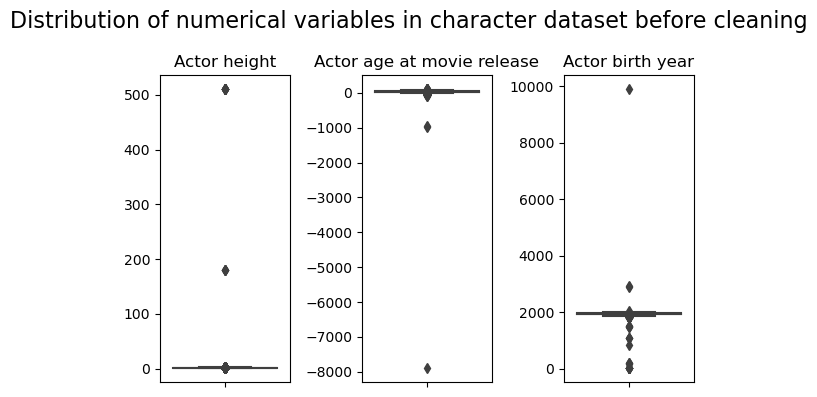

In [7]:
character_metadata_subset = character_metadata[['Actor height', 'Actor age at movie release', 'Actor birth year']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
fig.suptitle('Distribution of numerical variables in character dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(character_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=character_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/before_cleaning_character', dpi=1000, bbox_inches='tight')
plt.show()

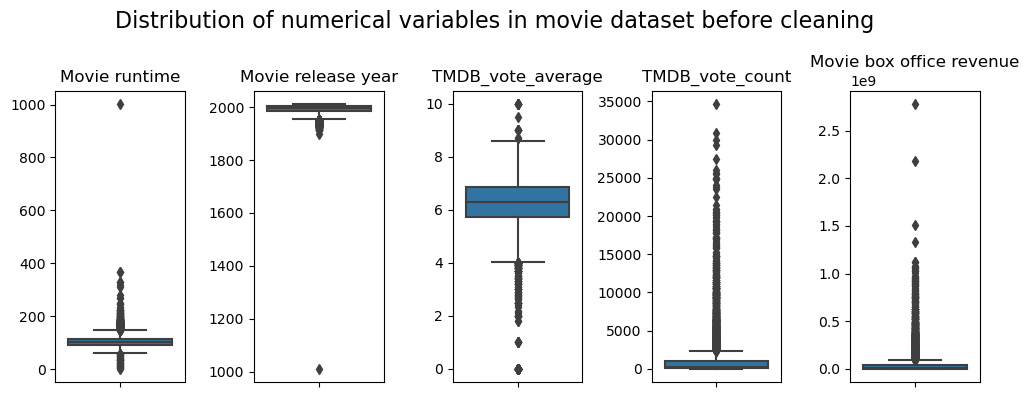

In [8]:
movie_metadata_subset = movie_metadata[['Movie runtime', 'Movie release year', 'TMDB_vote_average','TMDB_vote_count', 'Movie box office revenue']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in movie dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(movie_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=movie_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
#plt.savefig('figures/dist_and_clean/before_cleaning_movie', dpi=1000, bbox_inches='tight')
plt.show()

## Remove outliers

### Character dataset

Now we look more closely at each attribute and remove unrealistic values. We first take a look at **Movie release year**:

In [9]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)


In [10]:
# Find all unique years as sort them
get_min_and_max(df=character_metadata, variable_name='Movie release year', no_min=5, no_max=5)

5 minimum values of 'Movie release year':
[   0. 1010. 1888. 1891. 1893.]


5 maximum values of 'Movie release year':
[2012. 2013. 2014. 2015. 2016.]


We remove values below year 1800.

In [11]:
condition1 = (character_metadata['Movie release year'] < 1800)
condition2 = (movie_metadata['Movie release year'] < 1800)

character_metadata.loc[condition1, 'Movie release year'] = np.nan
movie_metadata.loc[condition2, 'Movie release year'] = np.nan

We now take a look at **Actor birth year**:

In [12]:
get_min_and_max(df=character_metadata, variable_name='Actor birth year', no_min=15, no_max=5)

15 minimum values of 'Actor birth year':
[   0.   19.  183.  195.  852. 1075. 1474. 1498. 1796. 1804. 1828. 1829.
 1835. 1836. 1837.]


5 maximum values of 'Actor birth year':
[2011. 2050. 2896. 2936. 9900.]


We see, that some birth years are unrealistic and decide to remove birth years, that are below 1700 and above 2016 (last movie release year).

In [13]:
# Define the condition to identify rows where 'Actor birth year' needs to be set to NaN
condition = (character_metadata['Actor birth year'] < 1700) | (character_metadata['Actor birth year'] > 2016)
character_metadata.loc[condition, 'Actor birth year'] = np.nan

We now look at **Actor height**:

In [14]:
get_min_and_max(df=character_metadata, variable_name='Actor height', no_min=15, no_max=15)

15 minimum values of 'Actor height':
[0.      0.61    0.813   0.83    0.88    0.94    1.      1.06    1.067
 1.07    1.09728 1.1176  1.12    1.14    1.143  ]


15 maximum values of 'Actor height':
[  2.11      2.13      2.134     2.16      2.161     2.18      2.2
   2.24      2.28      2.29      2.31      2.31648   2.356   180.
 510.     ]


Again, we remove unrealistic values, which are people with a height more than 2.4 meter. The people with small heights are probably kids, but we leave these for now.

In [15]:
# Define the condition to identify rows where height needs to be set to NaN
condition = (character_metadata['Actor height'] > 2.4)
character_metadata.loc[condition, 'Actor height'] = np.nan

We now look at **Actor age at movie release**:

In [16]:
get_min_and_max(df=character_metadata, variable_name='Actor age at movie release', no_min=20, no_max=20)

20 minimum values of 'Actor age at movie release':
[-7896.  -969.  -937.   -81.   -76.   -65.   -63.   -57.   -53.   -51.
   -50.   -48.   -47.   -44.   -43.   -42.   -39.   -38.   -37.   -36.]


20 maximum values of 'Actor age at movie release':
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  99. 103.]


We remove ages, that are less than 0 and higher than 110.

In [17]:
# Define the condition to identify rows where age needs to be set to NaN
condition = (character_metadata['Actor age at movie release'] < 0) | (character_metadata['Actor age at movie release'] > 110)
character_metadata.loc[condition, 'Actor age at movie release'] = np.nan

### Movie dataset

Let's begin by looking at **Movie runtime**:


In [18]:
# Fill missing values in 'Movie_runtime' with values from 'TMDB_runtime'
movie_metadata['Movie runtime'] = movie_metadata['Movie runtime'].fillna(movie_metadata['TMDB_runtime'])
movie_metadata['Movie runtime'].isna().sum()

37

In [19]:
get_min_and_max(df=movie_metadata, variable_name='Movie runtime', no_min=15, no_max=15)

15 minimum values of 'Movie runtime':
[ 0.   1.5  4.5  5.   6.  10.  12.  13.  16.  20.  21.  24.  25.  26.
 30. ]


15 maximum values of 'Movie runtime':
[ 224.  225.  231.  234.  246.  248.  250.  268.  269.  280.  312.  320.
  330.  366. 1003.]


We decide to only look at movies that have a maximum runtime of 500 minutes.

In [20]:
condition = (movie_metadata['Movie runtime'] > 500) | (movie_metadata['Movie runtime'] <= 0)
movie_metadata.loc[condition, 'Movie runtime'] = np.nan

Now let's take a look at **Movie box office revenue**:

In [21]:
get_min_and_max(df=movie_metadata, variable_name='Movie box office revenue', no_min=10, no_max=10)

10 minimum values of 'Movie box office revenue':
[ 1.  3. 10. 12. 13. 17. 18. 21. 25. 27.]


10 maximum values of 'Movie box office revenue':
[1.04387180e+09 1.06317191e+09 1.06565981e+09 1.07800895e+09
 1.11992952e+09 1.12374700e+09 1.32811122e+09 1.51175791e+09
 2.18537230e+09 2.78227517e+09]


As the box office revenue can have a huge span, and we don't have any negative values, we leave this for now.

In [22]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_vote_count', no_min=10, no_max=10)

10 minimum values of 'TMDB_vote_count':
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


10 maximum values of 'TMDB_vote_count':
[24843. 24994. 25554. 25601. 26088. 27446. 29290. 29943. 30843. 34697.]


We see that a lot of movies have 0 vote counts and the data is heavily tailed. It does not make sense to include data for movies where the vote count is 0. We can first try get an overview over how much data we would loose if we filter out only the movies with 0 votes. Then we look at other cut-off values to get an overview. 

In [23]:
# Create a copy of the original DataFrame for comparison
original_df = movie_metadata.copy()

# Define a list of cutoff values to test
cutoff_values = [0, 1, 2, 4, 6, 8, 10, 20, 50]  # Add more values as needed

# Create a dictionary to store results
data_loss_results = {'Cutoff Value': [], 'Data Loss Percentage': [], 'Data Length': []}

# Iterate through cutoff values
for cutoff in cutoff_values:
    # Create a condition based on the cutoff
    condition = (original_df['TMDB_vote_count'] >= cutoff)
    
    # Apply the condition to filter the DataFrame
    filtered_df = original_df[condition]
    
    # Calculate the percentage of data loss
    data_loss_percentage = ((len(original_df) - len(filtered_df)) / len(original_df)) * 100
    data_length = len(filtered_df)

    # Append the results to the dictionary
    data_loss_results['Cutoff Value'].append(cutoff)
    data_loss_results['Data Loss Percentage'].append(data_loss_percentage)
    data_loss_results['Data Length'].append(data_length)

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(data_loss_results)

# Print or visualize the results
results_df


Cutoff Value  Data Loss Percentage  Data Length
0             0              0.000000         8674
1             1              1.302744         8561
2             2              2.005995         8500
3             4              3.331796         8385
4             6              4.565368         8278
5             8              6.075628         8147
6            10              7.320729         8039
7            20             12.808393         7563
8            50             23.991238         6593

In [24]:
condition = (movie_metadata['TMDB_vote_count'] >= 20)
movie_metadata = movie_metadata[condition]

## Transformation of skewed variables

The plots show, that **Movie box office** and **TMDB_vote_count** have a highly right skewed distribution, also called a power law. We would need to transform these attributes for further analysis.

The variable **Movie runtime** seem fairly normally distributed. The variable **Movie release year** is left skewed, so we will also try to apply a log transform to this.

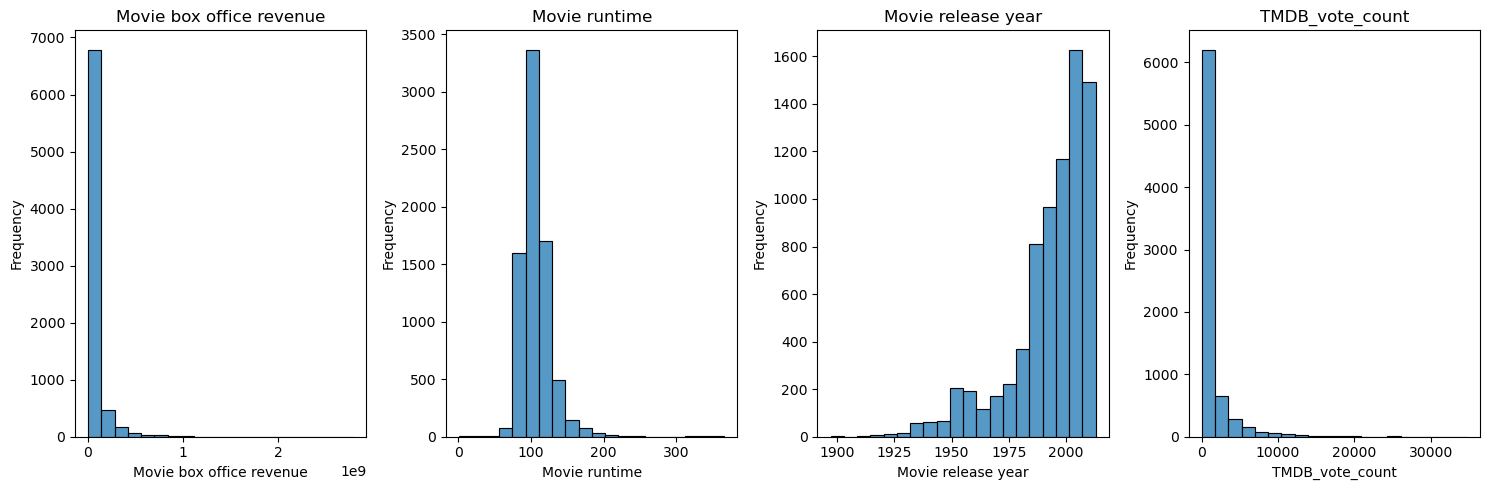

In [25]:
numerical_variables = ['Movie box office revenue', 'Movie runtime', 'Movie release year', 'TMDB_vote_count']

# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(numerical_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

After testing, we see that it only makes sense to transform **Movie box office revenue** and **TMDB_vote_count**.

In [26]:
movie_metadata['log Movie box office revenue'] = np.log(movie_metadata['Movie box office revenue'])

movie_metadata['log TMDB_vote_count'] = np.log(movie_metadata['TMDB_vote_count'])

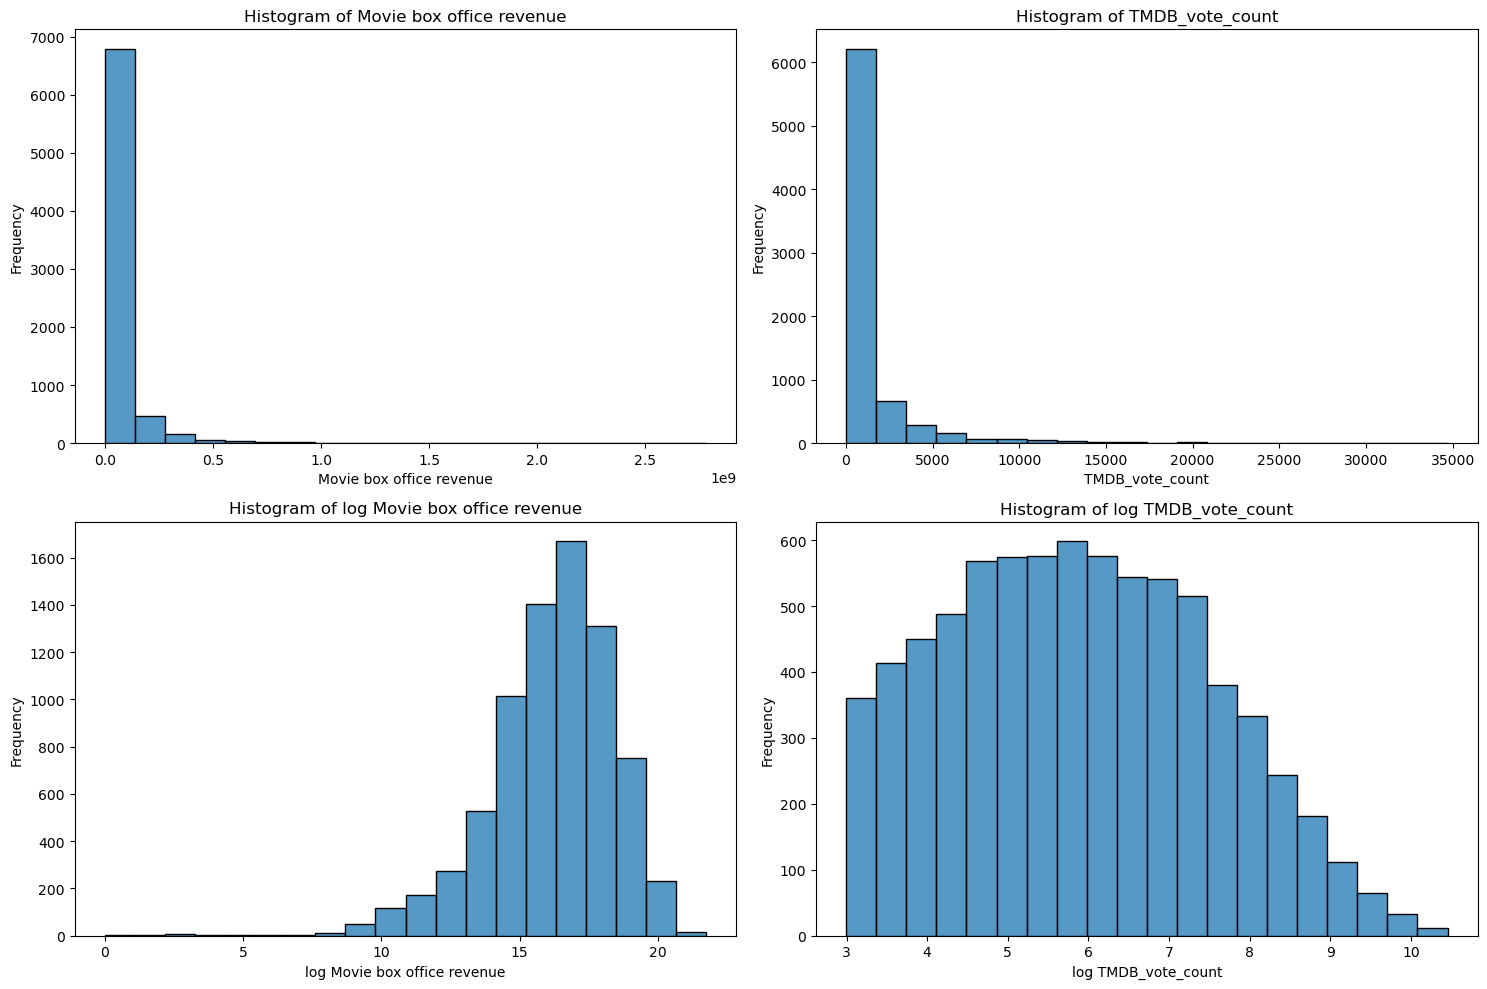

In [27]:
# Original variables
original_variables = ['Movie box office revenue','TMDB_vote_count']

# Log-transformed variables
log_variables = ['log Movie box office revenue', 'log TMDB_vote_count']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot original variables
for i, variable in enumerate(original_variables):
    ax = axes[0, i]
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of ' + variable)

# Plot log-transformed variables
for i, variable in enumerate(log_variables):
    ax = axes[1, i]
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of ' + variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


After the log transform, **Movie box office revenue** and **TMDB_vote_count** is fairly normally distributed.

## Missing values

Let's look at the amount of missing values in our data. For each attribute, the percentage of missing values is calculated.

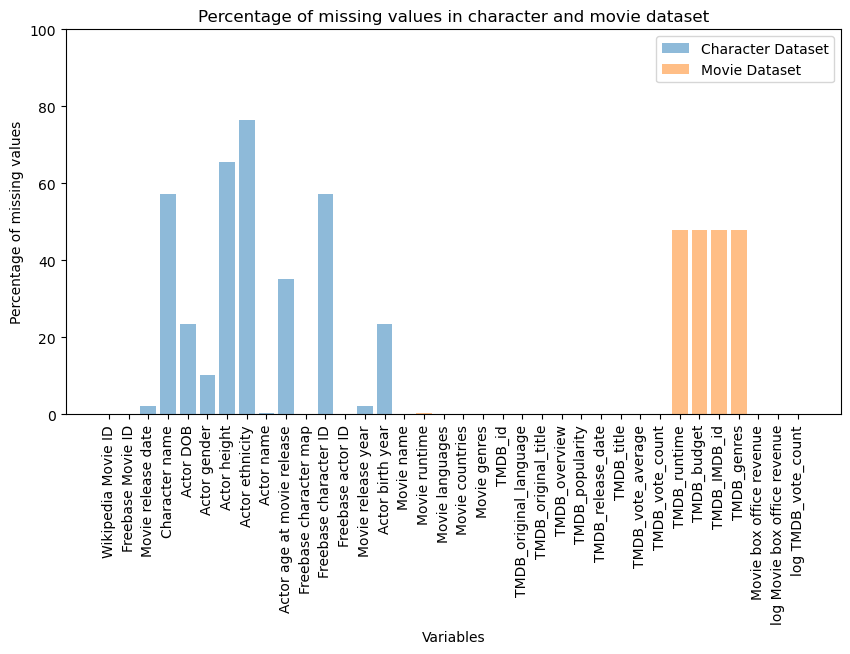

In [28]:
# Calculate percentage of missing values for each attribute
character_nan_percentages = character_metadata.isna().mean() * 100
movie_nan_percentages = movie_metadata.isna().mean() * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the character dataset NaN percentages
ax.bar(character_nan_percentages.index, character_nan_percentages, label='Character Dataset', alpha=0.5)

# Plot the movie dataset NaN percentages
ax.bar(movie_nan_percentages.index, movie_nan_percentages, label='Movie Dataset', alpha=0.5)

ax.set_ylim(0,100)
ax.set_xlabel('Variables')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of missing values in character and movie dataset')
ax.legend()
plt.xticks(rotation=90)
plt.show()

As we can see, there is a lot of missing values for some of the attributes. Especially **Movie box office revenue** has a lot of missing values (around 90%). We have already enriched the this attribute with more data, but it is still lacking, Despite the amount of missing values, we decide to work with it, since this attribute still has around 10'000 data points.

Some character attributes like height and ethnicity are also missing.

## Distribution of variables after cleaning

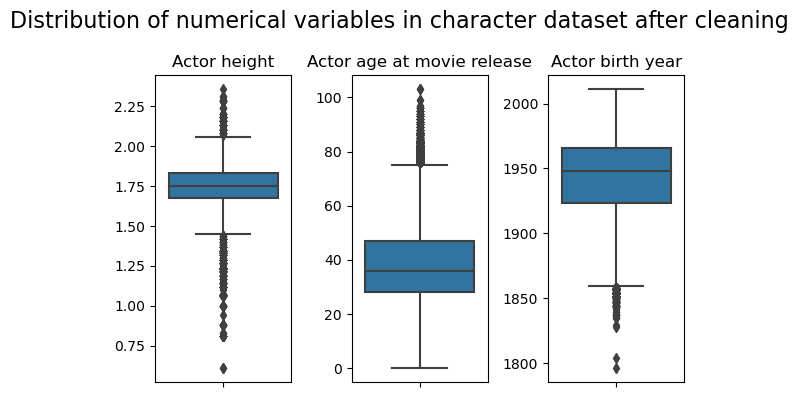

In [29]:
character_metadata_subset = character_metadata[['Actor height', 'Actor age at movie release', 'Actor birth year']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
fig.suptitle('Distribution of numerical variables in character dataset after cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(character_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=character_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
#plt.savefig('figures/dist_and_clean/after_cleaning_character', dpi=1000, bbox_inches='tight')
plt.show()

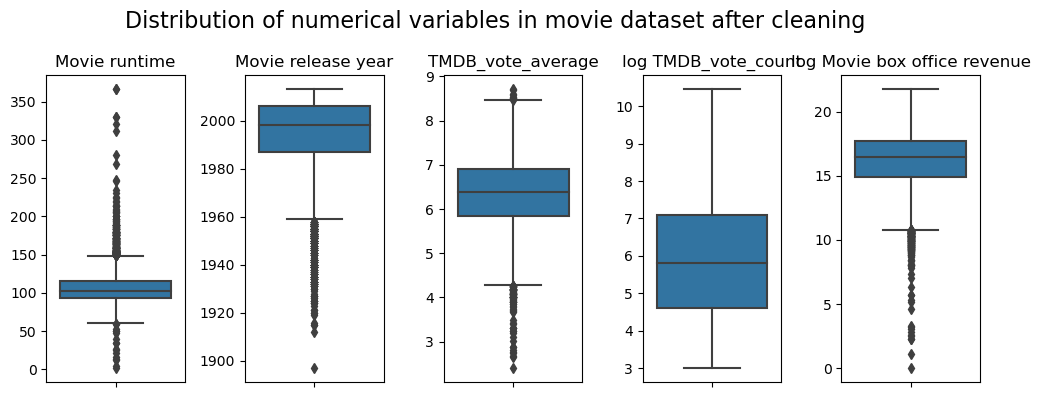

In [30]:
movie_metadata_subset = movie_metadata[['Movie runtime', 'Movie release year', 'TMDB_vote_average','log TMDB_vote_count', 'log Movie box office revenue']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in movie dataset after cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(movie_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=movie_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
#plt.savefig('figures/dist_and_clean/after_cleaning_movie', dpi=1000, bbox_inches='tight')
plt.show()

### Categorical values

Let us take a look at the categorical values.

In [31]:
movie_metadata[['Movie genres', 'Movie languages', 'Movie countries']].head()

Movie genres  \
0   {"/m/01jfsb": "Thriller", "/m/06n90": "Science...   
13  {"/m/04xvh5": "Costume drama", "/m/082gq": "Wa...   
17  {"/m/0hj3myq": "Children's/Family", "/m/04t36"...   
29  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...   
47  {"/m/0vgkd": "Black comedy", "/m/01z4y": "Come...   

                       Movie languages  \
0   {"/m/02h40lc": "English Language"}   
13  {"/m/02h40lc": "English Language"}   
17  {"/m/02h40lc": "English Language"}   
29  {"/m/02h40lc": "English Language"}   
47  {"/m/02h40lc": "English Language"}   

                                      Movie countries  
0           {"/m/09c7w0": "United States of America"}  
13                     {"/m/07ssc": "United Kingdom"}  
17          {"/m/09c7w0": "United States of America"}  
29          {"/m/09c7w0": "United States of America"}  
47  {"/m/09c7w0": "United States of America", "/m/...

We convert all the values for consistency and check all unique values.

In [32]:
# Define categorical variables
categorical_variables = ['Movie genres', 'Movie languages', 'Movie countries']

# Transform categorical_variables to lists of strings
for variable in categorical_variables:
    cleaned_column_name = f"{variable}"
    movie_metadata[cleaned_column_name] = movie_metadata[variable].apply(lambda x: ", ".join(eval(x).values()) if isinstance(eval(x), dict) else "")
    
    # Remove 'Language' or ' language' from entries in the 'Movie languages' column
    if variable == 'Movie languages':
        movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].str.replace(' Language', '').str.replace(' language', '')
    
    # Convert the string representation to a list
    movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].apply(lambda x: x.split(', ') if x else [])


In [33]:
# Find unique original languages
unique_original_languages = movie_metadata['TMDB_original_language'].unique()
print(f"Number of original unique languages: {len(unique_original_languages)}")

display(unique_original_languages)

Number of original unique languages: 37


array(['en', 'es', 'sr', 'ko', 'tr', 'fr', 'hi', 'pt', 'ml', 'it', 'cn',
       'el', 'th', 'zh', 'de', 'ro', 'ru', 'cs', 'ar', 'ja', 'sv', 'da',
       'nl', 'ta', 'fa', 'he', 'fi', 'iu', 'pl', 'mn', 'te', 'hu', 'vi',
       'is', 'bg', 'no', 'tn'], dtype=object)

In [34]:
# Find unique movie languages

# Split the languages and create a new data frame with expanded rows
languages_df = movie_metadata['Movie languages'].explode().reset_index()

# Count the unique languages
unique_languages = languages_df['Movie languages'].unique()
print(f"Number of unique languages: {len(unique_languages)}")

display(unique_languages)

Number of unique languages: 142


array(['English', 'Afrikaans', 'Spanish', 'Romani', 'Italian',
       'Serbo-Croatian', 'Bulgarian', 'Serbian', 'German', 'Korean',
       'French', 'Standard Mandarin', 'Standard Cantonese', 'Turkish',
       'American English', nan, 'Hindi', 'Japanese', 'Malayalam', 'Czech',
       'Slovak', 'Thai', 'Polish', 'Greek', 'Ancient Greek', 'Arabic',
       'Cantonese', 'Hungarian', 'Russian', 'Dutch', 'American Sign',
       'Silent film', 'Romanian', 'Welsh', 'Hebrew', 'Zulu', 'Latin',
       'Portuguese', 'Urdu', 'Mandarin Chinese', 'Chinese', 'Irish',
       'Yiddish', 'Swahili', 'Somali', 'Swedish', 'Navajo', 'Danish',
       'Algonquin', 'Ukrainian', 'Macedonian', 'Aramaic', 'Esperanto',
       'Quechua', 'Maya', 'Yucatán', 'Malay', 'Tamil', 'Vietnamese',
       'Bengali', 'Persian', 'Croatian', 'Scottish Gaelic', 'Catalan',
       'Old English', 'Icelandic', 'Apache', 'Western', 'Finnish',
       'Punjabi', 'Inuktitut', 'Estonian', 'Burmese', 'Armenian',
       'Mongolian', 'Telugu'

## Adding extra columns for exploration

**Percentage of male actors per movie**

In [35]:
#Group character_metadata by 'Wikipedia Movie ID' and calculate the percentage of male/female actors in each movie
male_percentage_per_movie = character_metadata.groupby('Wikipedia Movie ID')['Actor gender'].apply(lambda x: (x == 'M').sum() / len(x) * 100).reset_index()
male_percentage_per_movie.columns = ['Wikipedia Movie ID', 'Male_actor_percentage']

# Merge the male_percentage_per_movie dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, male_percentage_per_movie, on='Wikipedia Movie ID', how='left')

**Average age of actors**

In [ ]:
# Group character_metadata by 'Wikipedia Movie ID' and calculate the average birth year of actors in each movie
average_actor_age_per_movie = character_metadata.groupby('Wikipedia Movie ID')['Actor age at movie release'].mean().reset_index()
average_actor_age_per_movie.columns = ['Wikipedia Movie ID', 'Mean_actor_age_at_movie_release']

# Merge the dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, average_actor_age_per_movie, on='Wikipedia Movie ID', how='left')

# Remove unrealistic values
condition = (movie_metadata['Mean_actor_age_at_movie_release'] < 1) 
movie_metadata.loc[condition, 'Mean_actor_age_at_movie_release'] = np.nan


## Distribution of variables in the character dataset

We now want to look at the distribution of the attributes of the characters metadata set. We divide the character dataset into male and female character dataset, and use box plots and histograms to look at the distribution on the attributes. We also perform a t-test for each of the attributes with the nul-hypothesis: there is no difference between male and female.

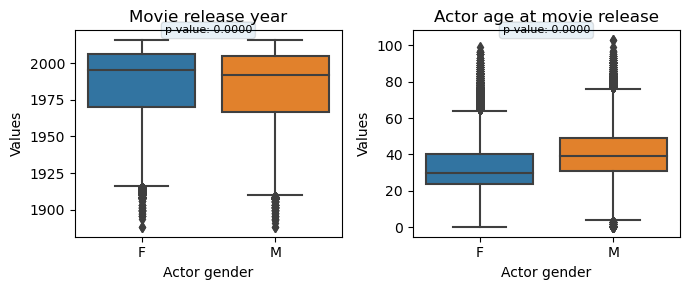

In [ ]:
# Variables of interest
#variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Variables of interest
variables = ['Movie release year', 'Actor age at movie release']

# Create a figure with four subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Create box plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Use sns.boxplot with 'Actor gender' as 'hue'
    sns.boxplot(x='Actor gender', y=variable, data=character_metadata, ax=ax)

    # Perform a t-test and get the p-value
    female_data = character_metadata[character_metadata['Actor gender'] == 'F'][variable].dropna()
    male_data = character_metadata[character_metadata['Actor gender'] == 'M'][variable].dropna()
    t_stat, p_value = stats.ttest_ind(female_data, male_data)

    # Annotate the plot with the p-value
    ax.annotate(f'p-value: {p_value:.4f}', xy=(0.5, max(ax.get_ylim())), ha='center', va='center',
                bbox=dict(boxstyle="round", alpha=0.1),
                fontsize=8, color='black')

    ax.set_ylabel('Values')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
#plt.savefig('figures/gender/boxplots.png', dpi=1000, bbox_inches='tight')
plt.show()


The first box plots show us, that more movies have been released in the more revent years. Naturally, the birth years of the actor are also more recent therefore. These also show us, that there is a significant difference in **Movie release year** and **Actor birth year** for male and female actors, where female actors are more represented in recent years. We might want to log-transform these attributes, if they are used in further analysis.

The height attribute shows that there is significant difference between the height of male and female, which makes sense, since men are naturally taller than woman.

The last box plot shows us, that there is a significant difference in the **Actor age at movie release** for male and female actors. It indicates, that female actors generally are younger than male actors in movies.

We also look at the distributions with a histogram:

### Explore **Actor age at movie release**

To explore the statistical difference further, we look at the attribute **Actor age at movie release** throughout all the years for female and male characters.

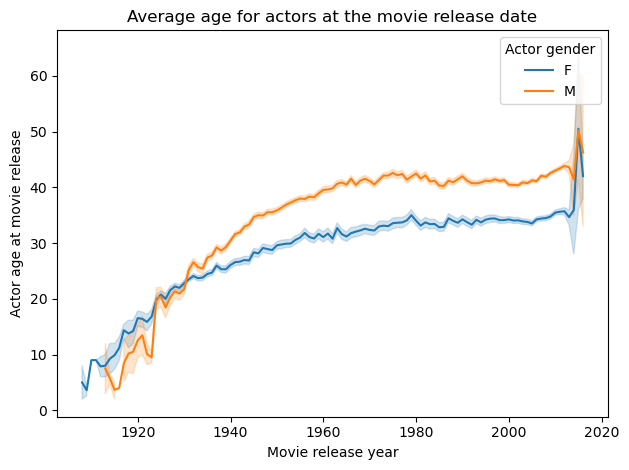

In [ ]:
# Remove NaNs from relevant columns
character_metadata_nona = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender']].dropna()
sns.lineplot(x='Movie release year', y='Actor age at movie release', data=character_metadata_nona, hue="Actor gender", err_style="band")

plt.title('Average age for actors at the movie release date')
plt.xlabel('Movie release year')
plt.ylabel('Actor age at movie release')
plt.tight_layout()
#plt.savefig('figures/gender/gender_age.png', dpi=1000, bbox_inches='tight')
plt.show()


The plot is very strange up until around 1930. It seems that actors are very young (20 years or younger on average).

However, the plot shows that female actors are significantly younger than male actors from around year 1930 and forward.

In [ ]:
# We add Movie box office revenue to the character dataset
character_metadata_with_rev = character_metadata.merge(movie_metadata[['Wikipedia Movie ID', 'Movie box office revenue', 'log Movie box office revenue']], 
                                                      how='inner', 
                                                      on='Wikipedia Movie ID')

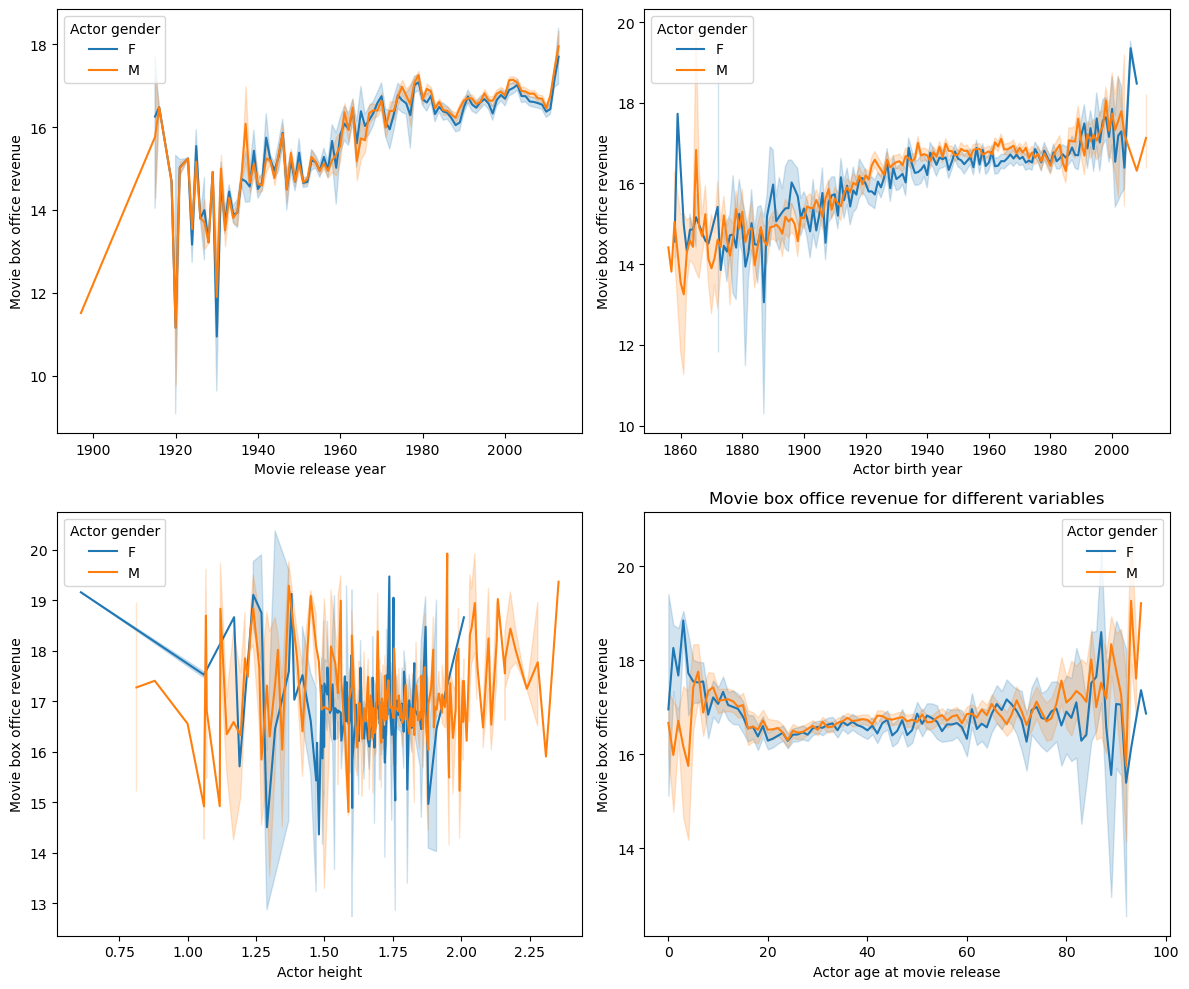

In [ ]:

# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create line plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Filter data and drop missing values
    #data_variable = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender', variable]].dropna()

    # Use sns.lineplot with 'Actor gender' as 'hue'
    sns.lineplot(data=character_metadata_with_rev, x=variable, y='log Movie box office revenue', hue="Actor gender", err_style="band", ax=ax)

    ax.set_ylabel('Movie box office revenue')
    ax.set_xlabel(variable)
    ax.legend(title='Actor gender')

# Adjust the layout to prevent overlapping
plt.title('Movie box office revenue for different variables')
plt.tight_layout()
plt.show()

There seems to be no significance difference between male and female actors, since all confidence intervals overlap.

## Inflation
Let's check, if the inflation rate has changed significantly.

In [ ]:
subset_rev_year = movie_metadata[['Movie release year', "log Movie box office revenue"]].dropna()

# Perform linear regression
X = subset_rev_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = subset_rev_year["log Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                                 OLS Regression Results                                 
Dep. Variable:     log Movie box office revenue   R-squared:                       0.026
Model:                                      OLS   Adj. R-squared:                  0.026
Method:                           Least Squares   F-statistic:                     203.1
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):           1.70e-45
Time:                                  13:10:20   Log-Likelihood:                -16691.
No. Observations:                          7563   AIC:                         3.339e+04
Df Residuals:                              7561   BIC:                         3.340e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Since the value of the US dollar is not the same now as it was in 1800, we have to take inflation into account. Therefore we import a dataset containing the value of the dollar from 1800 to 2023 relative to the value in 1800. We divide **Movie box office revenue** with the inflation rate for each year. Finally we log transform getting the attribute **log balanced Movie box office revenue**.

In [ ]:
inflation_data = pd.read_csv('data/inflation_data.csv')
inflation_data.rename(columns={'year': 'Movie release year'}, inplace=True)

movie_metadata_inflation = movie_metadata.merge(inflation_data[['Movie release year', 'amount']], how='left', on='Movie release year')
movie_metadata_inflation.rename(columns={'amount': 'Dollar value'}, inplace=True)

movie_metadata['balanced Movie box office revenue'] = (movie_metadata_inflation['Movie box office revenue']) / (movie_metadata_inflation['Dollar value'])
movie_metadata['log balanced Movie box office revenue'] = np.log10((movie_metadata['balanced Movie box office revenue']))


In [ ]:
# Second subplot - Inflation of the dollar
sns.lineplot(data=movie_metadata_inflation, x='Movie release year', y='Dollar value', ax=axes[1])
plt.title('Inflation of the US dollar')
plt.xlabel('Year')
plt.ylabel('Dollar value with respect to the value in year 1800')

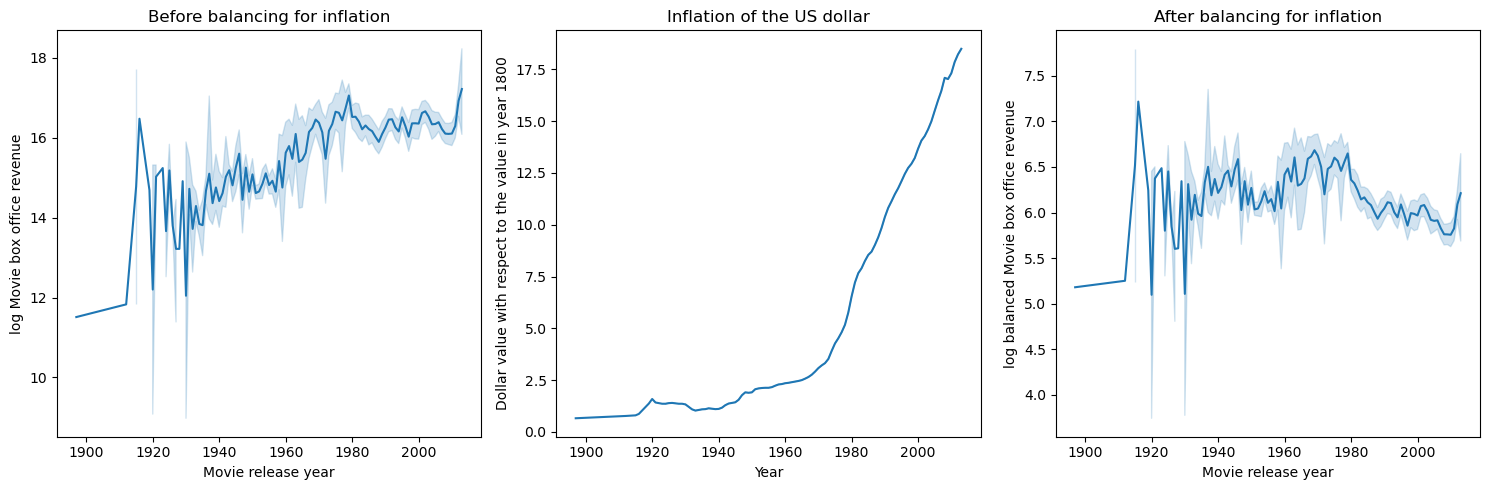

In [ ]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# First subplot - log Movie box office revenue trend
sns.lineplot(data=movie_metadata, x='Movie release year', y='log Movie box office revenue', ax=axes[0])
#sns.regplot(data=movie_metadata, x='Movie release year', y='log Movie box office revenue', scatter=False, ax=axes[0])
axes[0].set_title('Before balancing for inflation')
axes[0].set_xlabel('Movie release year')
axes[0].set_ylabel('log Movie box office revenue')

sns.lineplot(data=movie_metadata, x='Movie release year', y='log balanced Movie box office revenue', ax=axes[1])
#sns.regplot(data=movie_metadata, x='Movie release year', y='log balanced Movie box office revenue', scatter=False, ax=axes[2])
axes[1].set_title('After balancing for inflation')
axes[1].set_xlabel('Movie release year')
axes[1].set_ylabel('log balanced Movie box office revenue')

# Adjust layout
plt.tight_layout()
#plt.savefig("figures/dist_and_clean/inflation_plots.png", dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
subset_rev_year_balanced = movie_metadata[['Movie release year', "log balanced Movie box office revenue"]].dropna()

# Perform linear regression
X = subset_rev_year_balanced['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = subset_rev_year_balanced["log balanced Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                                      OLS Regression Results                                     
Dep. Variable:     log balanced Movie box office revenue   R-squared:                       0.019
Model:                                               OLS   Adj. R-squared:                  0.019
Method:                                    Least Squares   F-statistic:                     145.6
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):           3.19e-33
Time:                                           13:10:32   Log-Likelihood:                -10388.
No. Observations:                                   7563   AIC:                         2.078e+04
Df Residuals:                                       7561   BIC:                         2.079e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

After balancing for inflation, there seems to be a negative trend (Movie box office revenues are declining).

We will now save the cleaned dataset and keep working with this.

In [ ]:
# Save cleaned data sets
movie_metadata.to_csv('data_cleaned/movie_cleaned.csv')
character_metadata.to_csv('data_cleaned/character_cleaned.csv')

# The Different Dataset Attributes - Linear Models


## Gender representation in movies

We now want to further analyse our data by exploring the difference in representation of female and male actors in movies. We begin by counting the number of female and male actor in movies throughout the year


In [ ]:
# Load cleaned datasets
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv('data_cleaned/character_cleaned.csv')

In [ ]:
# Divide data set into male and female data set

female_characters = character_metadata[character_metadata['Actor gender'] == 'F']
male_characters = character_metadata[character_metadata['Actor gender'] == 'M']

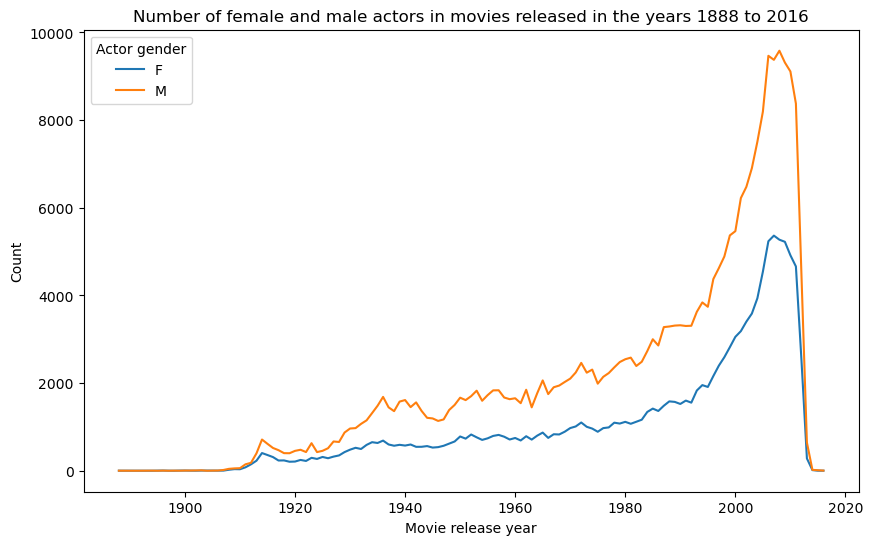

In [ ]:
gender_counts = character_metadata.groupby(['Movie release year', 'Actor gender']).size().reset_index(name='Count')
 
# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=gender_counts, x='Movie release year', y='Count', hue='Actor gender')
plt.title('Number of female and male actors in movies released in the years 1888 to 2016')
plt.xlabel('Movie release year')
plt.ylabel('Count')
plt.legend(title='Actor gender')
#plt.savefig("figures/gender/gender_count_release_year.png", dpi=1000, bbox_inches='tight')
plt.show()

As we can see, there are generally fewer female actors in movies than male actors.

Next, we will explore the percentage of female characters in movies throughout the years. Firstly, we calculate the percentage of females for each movie and then take the average over each year. We then make a linear regression to see, if there is a change of percentage of female actors in movies over the years.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.028
Model:                                      OLS   Adj. R-squared:                  0.018
Method:                           Least Squares   F-statistic:                     2.725
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):              0.102
Time:                                  13:10:41   Log-Likelihood:                -271.17
No. Observations:                            96   AIC:                             546.3
Df Residuals:                                94   BIC:                             551.5
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

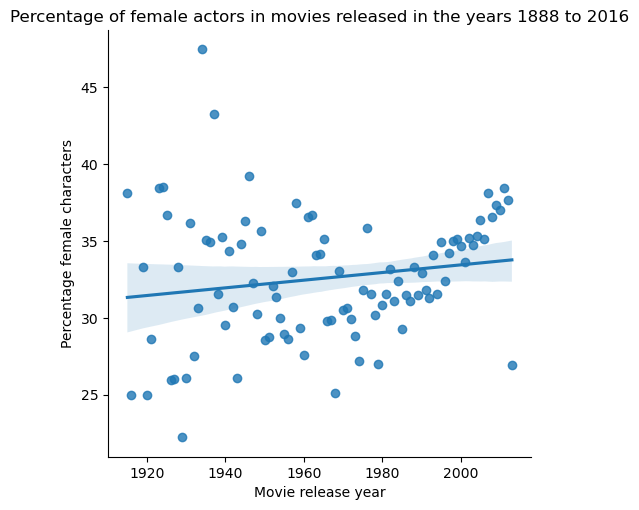

In [ ]:
# Count number of female in each movie
female_count = female_characters.groupby('Wikipedia Movie ID').size()
male_count = male_characters.groupby('Wikipedia Movie ID').size()

# Ensure that all Wikipedia Movie IDs in 'female_count' are represented in 'male_count'
# Fill missing values with 0
male_count = male_count.reindex(female_count.index, fill_value=0)

# Calculate the percentage of female characters
percentage_female = (female_count / (female_count + male_count)) * 100

# Reset the index to have 'Wikipedia Movie ID' as a column
percentage_female = percentage_female.reset_index()

# Rename the columns for clarity
percentage_female.columns = ['Wikipedia Movie ID', 'Percentage female characters']

# Merge dataframes
percentage_female_with_year = pd.merge(percentage_female, movie_metadata, on='Wikipedia Movie ID', how='left')

# Calculate female percentage pr. year and make into a data frame with column 'Movie release year' and 'Percentage female characters'
percentage_female_per_year = percentage_female_with_year.groupby('Movie release year')['Percentage female characters'].mean()
percentage_female_per_year = percentage_female_per_year.reset_index(name="Percentage female characters")
percentage_female_per_year['Movie release year'] = pd.to_numeric(percentage_female_per_year['Movie release year'], errors='coerce').astype(float)

# Drop missing values
percentage_female_per_year = percentage_female_per_year.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year)

# Perform linear regression
X = percentage_female_per_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female actors in movies released in the years 1888 to 2016')
#plt.savefig("figures/gender/female_percentage_release_year.png", dpi=1000, bbox_inches='tight')
plt.show()

The plot and linear regression indicates, that there is a significant no significant change of female characters over the years. But looking at the plot, there seems to be a trend from 1980 and forward. Let us look at that.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.397
Model:                                      OLS   Adj. R-squared:                  0.378
Method:                           Least Squares   F-statistic:                     21.04
Date:                          Wed, 20 Dec 2023   Prob (F-statistic):           6.58e-05
Time:                                  13:10:45   Log-Likelihood:                -72.294
No. Observations:                            34   AIC:                             148.6
Df Residuals:                                32   BIC:                             151.6
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

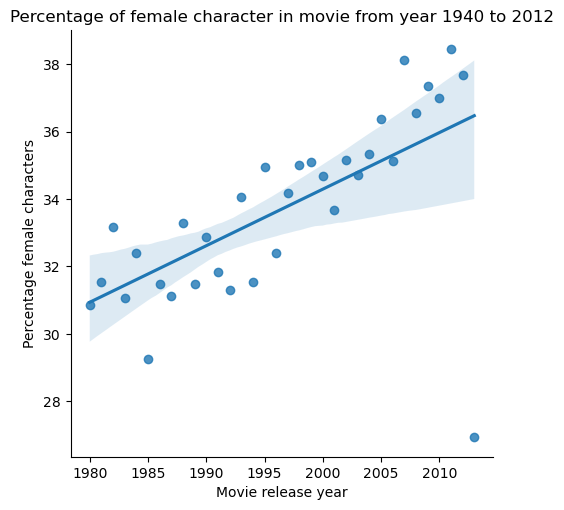

In [ ]:
condition = (percentage_female_per_year['Movie release year'] < 1980)
percentage_female_per_year_filtered = percentage_female_per_year
percentage_female_per_year_filtered.loc[condition, 'Movie release year'] = np.nan
percentage_female_per_year_filtered = percentage_female_per_year_filtered.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year_filtered)

# Perform linear regression
X = percentage_female_per_year_filtered['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year_filtered["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female character in movie from year 1940 to 2012')
#plt.savefig("figures/gender/female_percentage_release_year_filtered.png", dpi=1000, bbox_inches='tight')
plt.show()

This regression shows, that there is a significant increase in percentage of female actors from year 1980 and forward.

### Gender's affect on box office revenue

We will now see if percentage of female characters have a significant correlation with **Movie box office revenue**.

                                      OLS Regression Results                                     
Dep. Variable:     log balanced Movie box office revenue   R-squared:                       0.018
Model:                                               OLS   Adj. R-squared:                  0.018
Method:                                    Least Squares   F-statistic:                     130.9
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):           4.65e-30
Time:                                           13:10:53   Log-Likelihood:                -9743.4
No. Observations:                                   7183   AIC:                         1.949e+04
Df Residuals:                                       7181   BIC:                         1.950e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

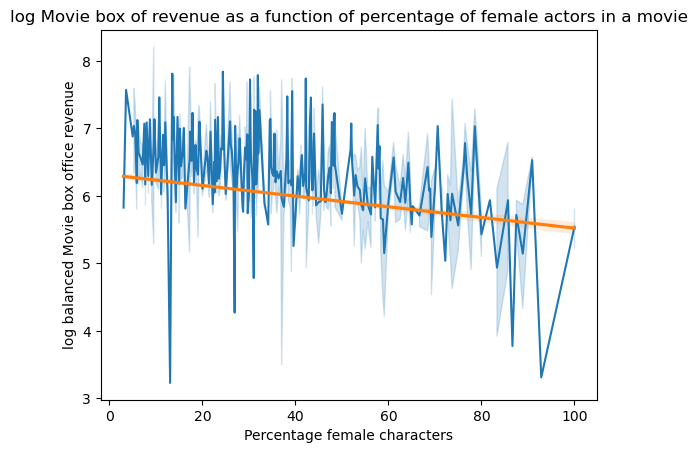

In [ ]:
# Define dataframe with 'log Movie box office revenue' and 'Percentage female characters'
percentage_female_with_log_rev = percentage_female_with_year[['log balanced Movie box office revenue', 'Percentage female characters']].dropna()

# Perform linear regression
X = percentage_female_with_log_rev["Percentage female characters"]
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_with_log_rev["log balanced Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

In [ ]:
# Define dataframe with 'log Movie box office revenue' and 'Percentage female characters'
percentage_female_with_log_rating = percentage_female_with_year[['TMDB_vote_average', 'Percentage female characters']].dropna()

# Perform linear regression
X = percentage_female_with_log_rating["Percentage female characters"]
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_with_log_rating["TMDB_vote_average"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

In [ ]:
# Define dataframe with 'TMDB_vote_average' and 'Percentage female characters'
percentage_female_with_tmdb = percentage_female_with_year[['TMDB_vote_average', 'Percentage female characters']].dropna()

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Create line plot and regression for 'log Movie box office revenue'
sns.lineplot(data=percentage_female_with_log_rev, x='Percentage female characters', y='log balanced Movie box office revenue', ax=axes[0])
sns.regplot(data=percentage_female_with_log_rev, x='Percentage female characters', y='log balanced Movie box office revenue', scatter=False, ax=axes[0])
axes[0].set_title('Revenue')
axes[0].set_xlabel('Percentage female characters')
axes[0].set_ylabel('log balanced Movie box office revenue')

# Create line plot and regression for 'TMDB_vote_average'
sns.lineplot(data=percentage_female_with_tmdb, x='Percentage female characters', y='TMDB_vote_average', ax=axes[1])
sns.regplot(data=percentage_female_with_tmdb, x='Percentage female characters', y='TMDB_vote_average', scatter=False, ax=axes[1])
axes[1].set_title('Rating')
axes[1].set_xlabel('Percentage female characters')
axes[1].set_ylabel('Rating')


plt.tight_layout()
#plt.savefig("figures/gender/female_percentage_rev_rating.png", dpi=1000, bbox_inches='tight')
plt.show()


## Functions for analysis

In [160]:
def linear_regression(df, dependent_variable, independent_variable):
    """
    Function 
    """
    # Declare the model
    formula = f"{dependent_variable} ~ {independent_variable}"
    mod = smf.ols(formula=formula, data=df)

    # Fit the model
    np.random.seed(2)
    res = mod.fit()

    # Print the summary output provided by the library
    print(res.summary())


In [161]:
def plot_dual_scatterplots(df, x_variable, dependent_variable1, dependent_variable2, xlabel_text, ylabel_text1, ylabel_text2, title1, title2):
    """
    Function to plot scatterplots with linear regression for two dependent variables against a single independent variable.
    Includes correlation coefficients and R^2 values on the plots.
    """
    # Handling missing data
    df = df.dropna(subset=[x_variable, dependent_variable1, dependent_variable2])

    # Calculate correlation coefficients and R^2 values
    corr_coef1, p_value1 = stats.pearsonr(df[x_variable], df[dependent_variable1])
    corr_coef2, p_value2 = stats.pearsonr(df[x_variable], df[dependent_variable2])
    r_squared1 = corr_coef1 ** 2
    r_squared2 = corr_coef2 ** 2
    

    palette = sns.color_palette()
    blue = palette[0]
    green = palette[1]

    # Setting up the matplotlib figure
    plt.figure(figsize=(15, 6))

    # Scatter plot with regression line for dependent_variable1
    plt.subplot(1, 2, 1)
    sns.regplot(x=x_variable, y=dependent_variable1, data=df, color=blue, scatter_kws={'alpha':0.5}, line_kws={'color':'black'})
    plt.text(0.05, 0.9, f"r={corr_coef1:.2f} \nR²={r_squared1:.2f}", transform=plt.gca().transAxes, fontsize=15)
    plt.title(title1, fontsize=16)
    plt.xlabel(xlabel_text, fontsize=15)
    plt.ylabel(ylabel_text1, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Scatter plot with regression line for dependent_variable2
    plt.subplot(1, 2, 2)
    sns.regplot(x=x_variable, y=dependent_variable2, data=df, color=green, scatter_kws={'alpha':0.5}, line_kws={'color':'black'})
    plt.text(0.05, 0.9, f"r={corr_coef2:.2f} \nR²={r_squared2:.2f}", transform=plt.gca().transAxes, fontsize=15)
    plt.title(title2, fontsize=16)
    plt.xlabel(xlabel_text, fontsize=15)
    plt.ylabel(ylabel_text2, fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    folder_path = os.path.join('figures', x_variable)
    os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, f'{x_variable}_scatterplot.png')
    
    #plt.savefig(file_path, dpi=1000)
    plt.tight_layout()
    plt.show()


In [162]:
# Load datasets
data_folder = './data_cleaned/'
movie_metadata = pd.read_csv(data_folder   + 'movie_cleaned.csv', lineterminator='\n')

# Replace spaces with underscores in column names
movie_metadata.columns = movie_metadata.columns.str.replace(' ', '_')


# Original movie langauge

In [51]:
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', sep=',')

# Create a new column 'is_english' with 1 if 'TMDB_original_language' is 'en' and 0 otherwise
movie_metadata['is_english'] = np.where(movie_metadata['TMDB_original_language'] == 'en', 1, 0)

In [52]:
# Perform linear regression
X = movie_metadata['is_english']
X = sm.add_constant(X)  # Add an intercept term
y = movie_metadata["log balanced Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                                      OLS Regression Results                                     
Dep. Variable:     log balanced Movie box office revenue   R-squared:                       0.038
Model:                                               OLS   Adj. R-squared:                  0.038
Method:                                    Least Squares   F-statistic:                     298.0
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):           1.62e-65
Time:                                           20:43:17   Log-Likelihood:                -10314.
No. Observations:                                   7563   AIC:                         2.063e+04
Df Residuals:                                       7561   BIC:                         2.065e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                 coe

In [58]:
# Perform linear regression
X = movie_metadata['is_english']
X = sm.add_constant(X)  # Add an intercept term
y = movie_metadata["TMDB_vote_average"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      TMDB_vote_average   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     221.4
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           2.22e-49
Time:                        20:49:08   Log-Likelihood:                -9098.3
No. Observations:                7563   AIC:                         1.820e+04
Df Residuals:                    7561   BIC:                         1.821e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7214      0.026    254.484      0.0

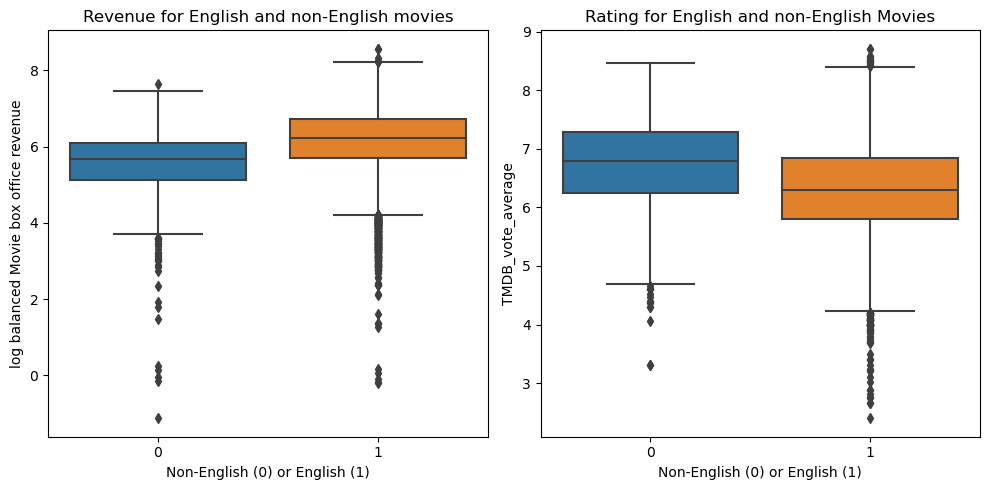

In [55]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Boxplot for 'log balanced Movie box office revenue'
sns.boxplot(x='is_english', y='log balanced Movie box office revenue', data=movie_metadata, ax=axes[0])
axes[0].set_title('Revenue for English and non-English movies')
axes[0].set_xlabel('Non-English (0) or English (1)')

# Boxplot for 'TMDB_vote_average'
sns.boxplot(x='is_english', y='TMDB_vote_average', data=movie_metadata, ax=axes[1])
axes[1].set_title('Rating for English and non-English Movies')
axes[1].set_xlabel('Non-English (0) or English (1)')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/language/boxplots.png', dpi=1000, bbox_inches='tight')
plt.show()

## Movie release year

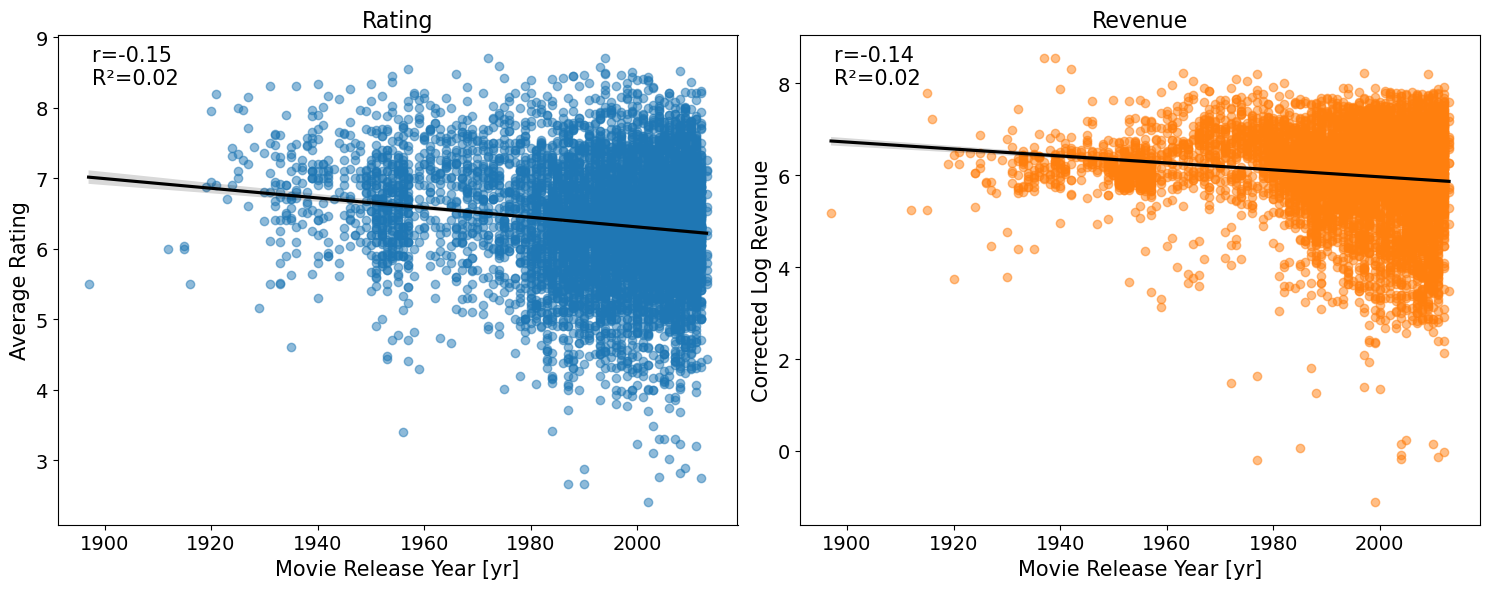

In [163]:
vote_average_label ='Average Rating'
revenue_label = 'Corrected Log Revenue'
score_title = 'Rating'
revenue_title = 'Revenue'
x_label = 'Movie Release Year [yr]'
plot_dual_scatterplots(movie_metadata,'Movie_release_year', 'TMDB_vote_average', 'log_balanced_Movie_box_office_revenue',x_label,vote_average_label, revenue_label, score_title, revenue_title)

In [164]:
linear_regression(movie_metadata,"Movie_release_year","TMDB_vote_average")
linear_regression(movie_metadata,"Movie_release_year","log_Movie_box_office_revenue")

                            OLS Regression Results                            
Dep. Variable:     Movie_release_year   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     166.8
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           9.31e-38
Time:                        21:34:16   Log-Likelihood:                -32303.
No. Observations:                7563   AIC:                         6.461e+04
Df Residuals:                    7561   BIC:                         6.462e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2013.2729      1.56

## Runtime



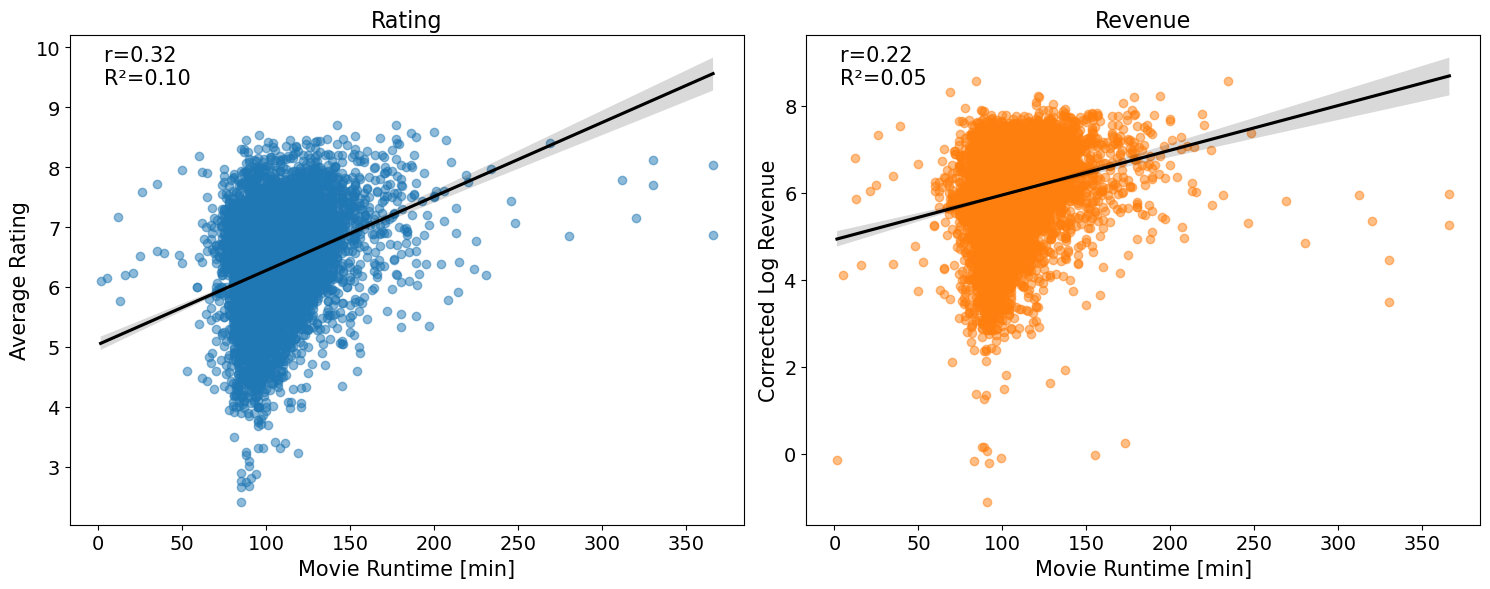

In [165]:
x_label = 'Movie Runtime [min]'
plot_dual_scatterplots(movie_metadata,'Movie_runtime', 'TMDB_vote_average', 'log_balanced_Movie_box_office_revenue',x_label,vote_average_label, revenue_label,score_title, revenue_title)

In [166]:
linear_regression(movie_metadata,"Movie_runtime","TMDB_vote_average")
linear_regression(movie_metadata,"Movie_runtime","log_Movie_box_office_revenue")

                            OLS Regression Results                            
Dep. Variable:          Movie_runtime   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     842.8
Date:                Wed, 20 Dec 2023   Prob (F-statistic):          9.67e-176
Time:                        21:34:40   Log-Likelihood:                -33233.
No. Observations:                7537   AIC:                         6.647e+04
Df Residuals:                    7535   BIC:                         6.648e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            54.7480      1.79

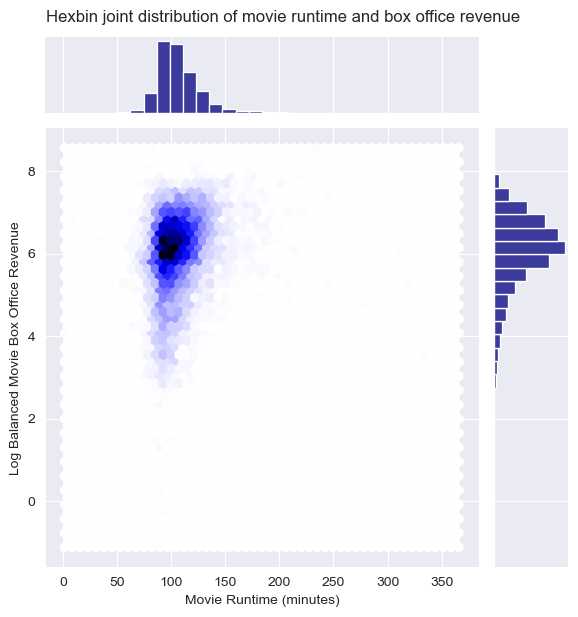

In [ ]:
    # Generate the hexbin plot with marginal histograms
sns.jointplot(
    data=movie_metadata,
    x="Movie_runtime",
    y="log_balanced_Movie_box_office_revenue",
    kind="hex",
    color="navy",
    marginal_kws=dict(bins=30, fill=True)
)

# Set labels and title
plt.xlabel('Movie Runtime (minutes)')
plt.ylabel('Log Balanced Movie Box Office Revenue')
plt.suptitle('Hexbin joint distribution of movie runtime and box office revenue', y=1.02)

# Show the plot
#plt.savefig(dpi=1000,fname='movie_runtimeVSlogbalanced_movieboxofficerevenue')
plt.show()

## Vote Count

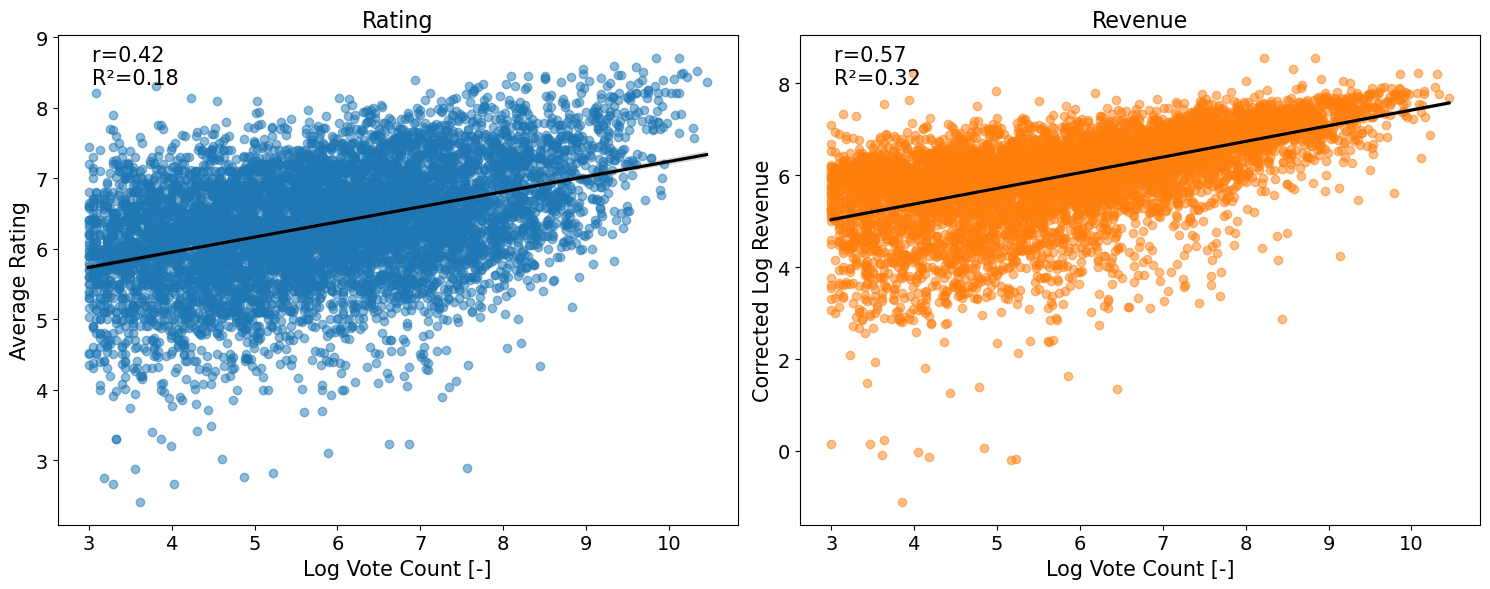

In [167]:
x_label = 'Log Vote Count [-]'
plot_dual_scatterplots(movie_metadata,'log_TMDB_vote_count', 'TMDB_vote_average', 'log_balanced_Movie_box_office_revenue',x_label,vote_average_label, revenue_label,score_title, revenue_title)

In [168]:
linear_regression(movie_metadata,"log_TMDB_vote_count","log_Movie_box_office_revenue")
linear_regression(movie_metadata,"log_TMDB_vote_count","TMDB_vote_average")

                             OLS Regression Results                            
Dep. Variable:     log_TMDB_vote_count   R-squared:                       0.412
Model:                             OLS   Adj. R-squared:                  0.412
Method:                  Least Squares   F-statistic:                     5297.
Date:                 Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                         21:35:02   Log-Likelihood:                -12325.
No. Observations:                 7563   AIC:                         2.465e+04
Df Residuals:                     7561   BIC:                         2.467e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Interc

## Male actor percentage

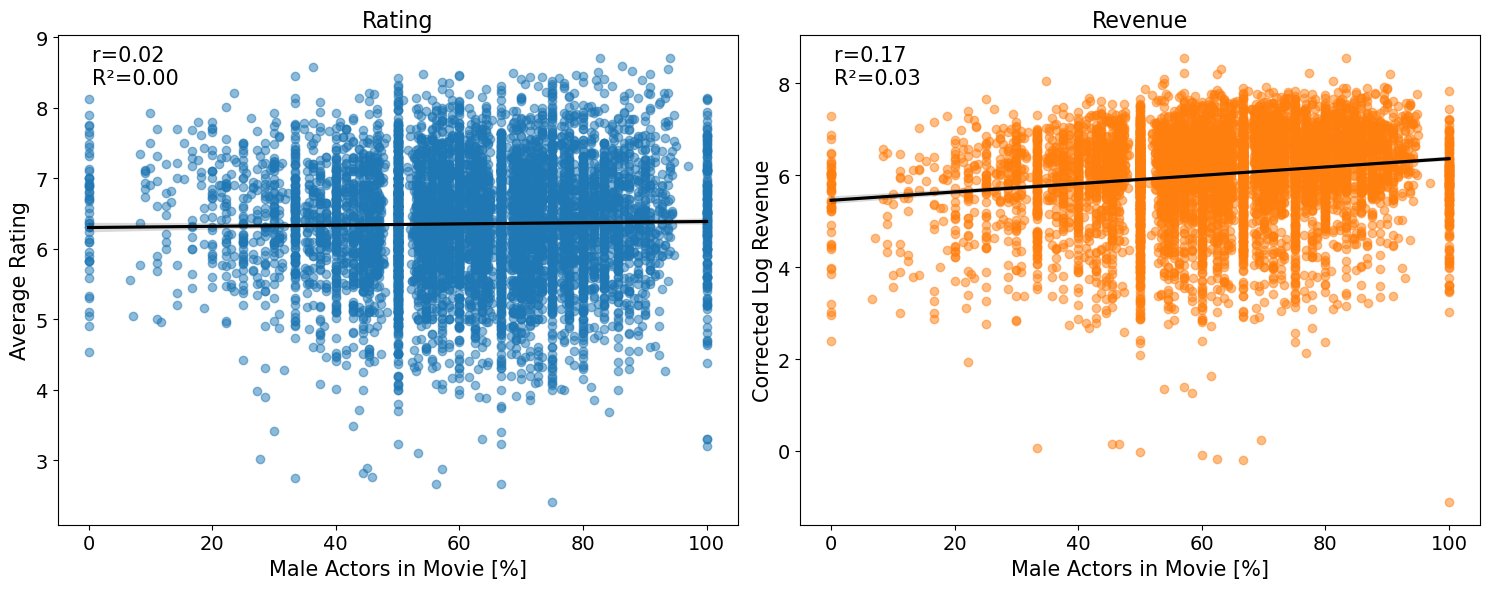

In [169]:
x_label = 'Male Actors in Movie [%]'
plot_dual_scatterplots(movie_metadata,'Male_actor_percentage', 'TMDB_vote_average', 'log_balanced_Movie_box_office_revenue',x_label,vote_average_label, revenue_label,score_title, revenue_title)

In [170]:
linear_regression(movie_metadata,"Male_actor_percentage","TMDB_vote_average")
linear_regression(movie_metadata,"Male_actor_percentage","log_Movie_box_office_revenue")

                              OLS Regression Results                             
Dep. Variable:     Male_actor_percentage   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     2.647
Date:                   Wed, 20 Dec 2023   Prob (F-statistic):              0.104
Time:                           21:35:19   Log-Likelihood:                -32235.
No. Observations:                   7493   AIC:                         6.447e+04
Df Residuals:                       7491   BIC:                         6.449e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

## Average actor age

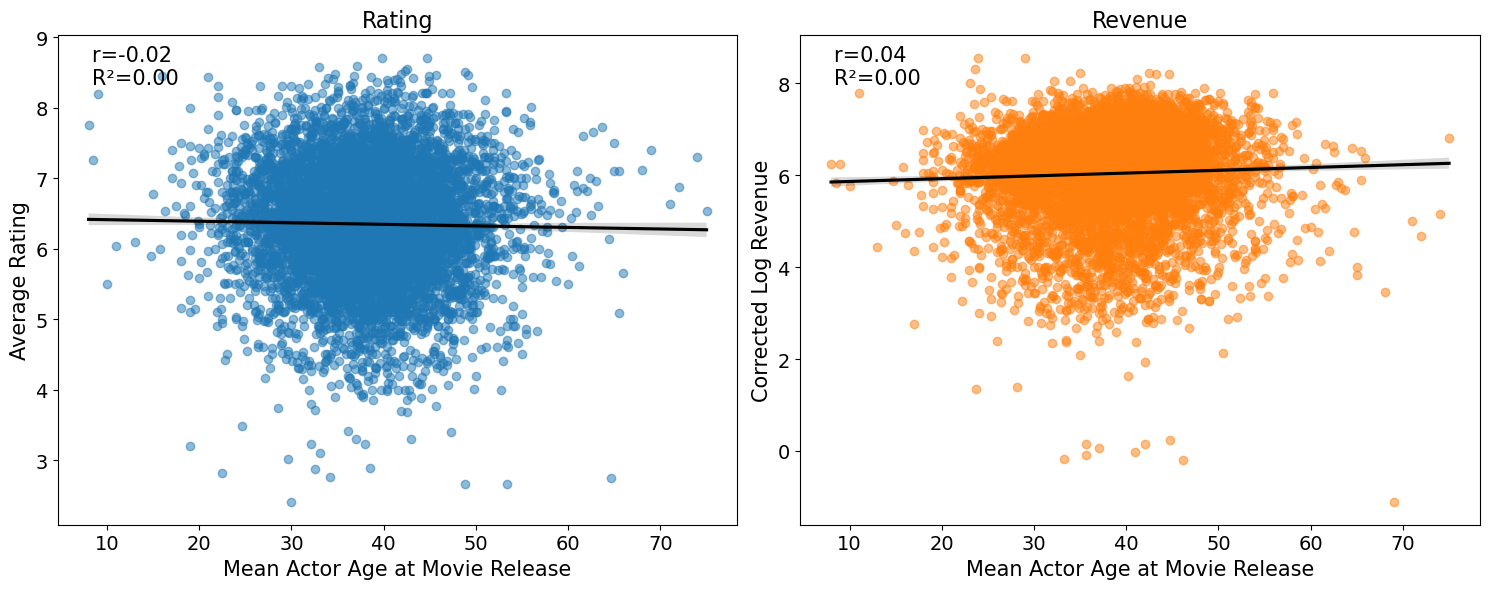

In [171]:
x_label = 'Mean Actor Age at Movie Release'
plot_dual_scatterplots(movie_metadata,'Mean_actor_age_at_movie_release', 'TMDB_vote_average', 'log_balanced_Movie_box_office_revenue',x_label,vote_average_label, revenue_label,score_title, revenue_title)


In [172]:
linear_regression(movie_metadata,"Mean_actor_age_at_movie_release","TMDB_vote_average")
linear_regression(movie_metadata,"Mean_actor_age_at_movie_release","log_Movie_box_office_revenue")

                                   OLS Regression Results                                  
Dep. Variable:     Mean_actor_age_at_movie_release   R-squared:                       0.000
Model:                                         OLS   Adj. R-squared:                  0.000
Method:                              Least Squares   F-statistic:                     2.585
Date:                             Wed, 20 Dec 2023   Prob (F-statistic):              0.108
Time:                                     21:35:35   Log-Likelihood:                -24532.
No. Observations:                             7301   AIC:                         4.907e+04
Df Residuals:                                 7299   BIC:                         4.908e+04
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0

## Combined Linear Model


In [4]:
movie_reg_data = movie_metadata[['Movie_runtime', 'TMDB_original_language', 'Movie_countries', 'Movie_genres', 'Movie_release_year', 
                                          'log_TMDB_vote_count', 'log_balanced_Movie_box_office_revenue', 'TMDB_vote_average', 
                                          'Male_actor_percentage', 'Mean_actor_age_at_movie_release']]
numeric_columns = movie_reg_data.select_dtypes(include=['number']).columns.tolist()
numeric_data = movie_reg_data[numeric_columns]
# Print the list of numeric columns
print(numeric_columns)

['Movie_runtime', 'Movie_release_year', 'log_TMDB_vote_count', 'log_balanced_Movie_box_office_revenue', 'TMDB_vote_average', 'Male_actor_percentage', 'Mean_actor_age_at_movie_release']


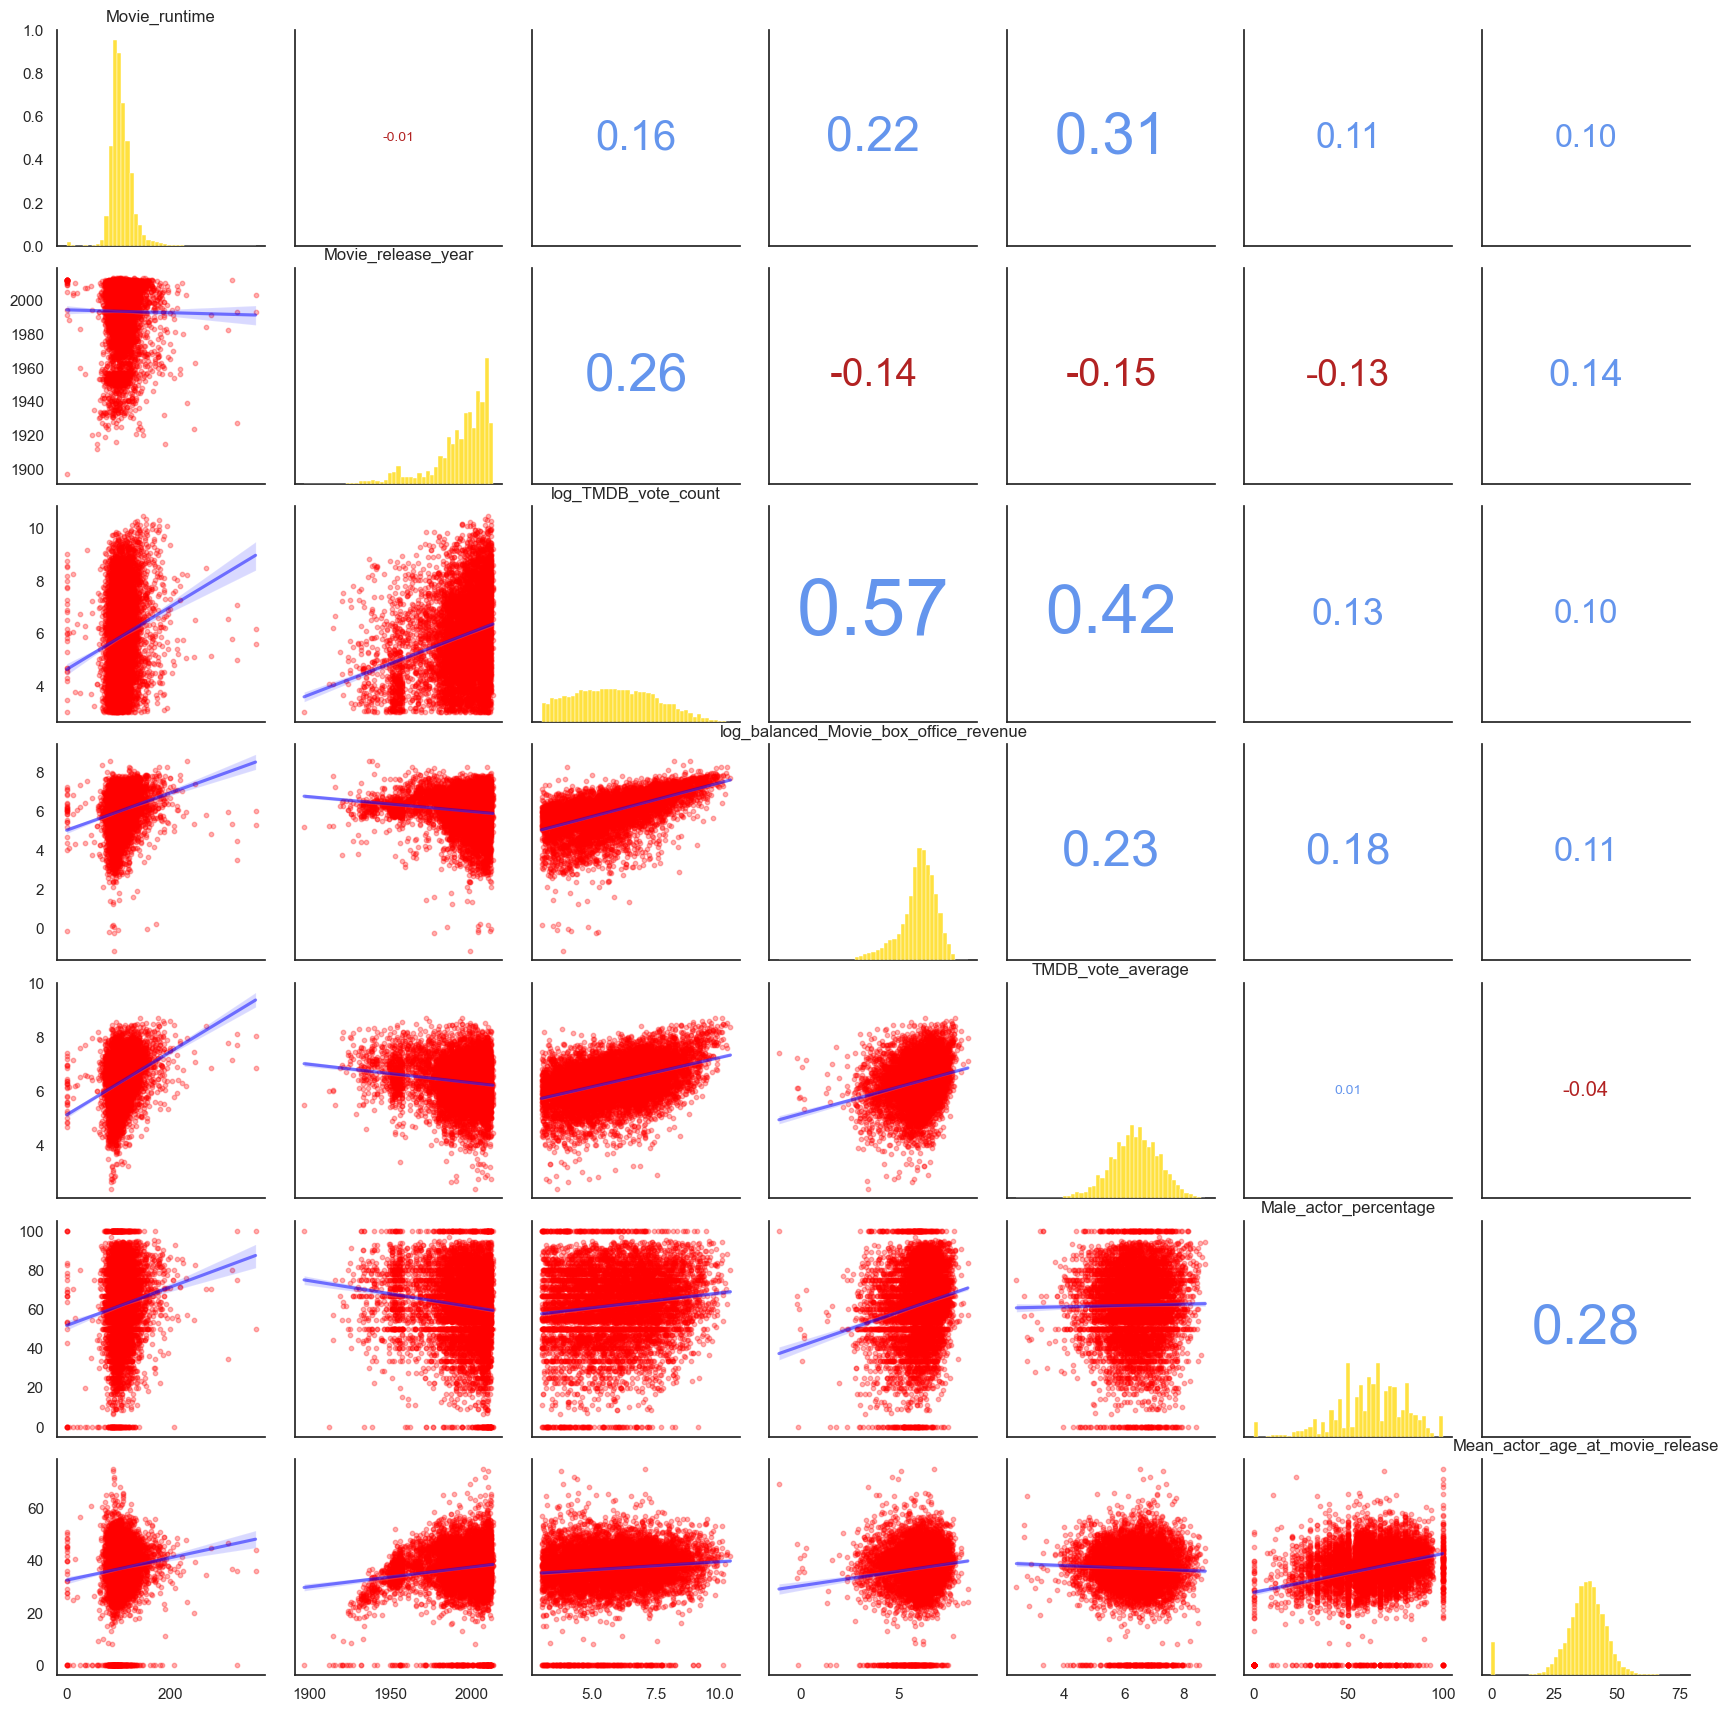

In [5]:

# Define the function for correlation
def corr_func(x, y, **kwargs):
    r = pearsonr(x, y)[0]
    ax = plt.gca()
    size = np.sqrt(np.abs(r)) * 75  # Non-linear scaling for size
    color = 'cornflowerblue' if r > 0 else 'firebrick'  # Blue for positive, red for negative
    ax.annotate(f"{r:.2f}", xy=(.5, .5), xycoords=ax.transAxes, 
                size=max(size, 10),  # Minimum size to ensure readability
                ha='center', va='center', color=color)

# Define the function to label diagonal plots
def label_diag(x, **kwargs):
    ax = plt.gca()
    ax.set_title(x.name)  # Set the title to the variable name

# Assuming numeric_data is defined
# Create an empty pairgrid with a custom color palette
sns.set(style="white", palette="husl")
grid = sns.PairGrid(numeric_data)

# Map the plots to the lower, upper, and diagonal elements of the pairgrid
grid = grid.map_upper(corr_func)  # Annotate correlation coefficients
grid = grid.map_lower(sns.regplot, scatter_kws={'color':'red','s': 10, 'alpha': 0.3}, line_kws={'color':'blue','alpha': 0.5})
grid = grid.map_diag(sns.histplot, color='gold', bins=45)  # Histograms
grid = grid.map_diag(label_diag)  # Label the diagonal with variable names

# Remove axis labels for x and y axes
for ax in grid.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

# Save the plot with high DPI
#plt.savefig(fname="plots/BOBsYndlingsPlot.png", dpi=1000)
plt.show()

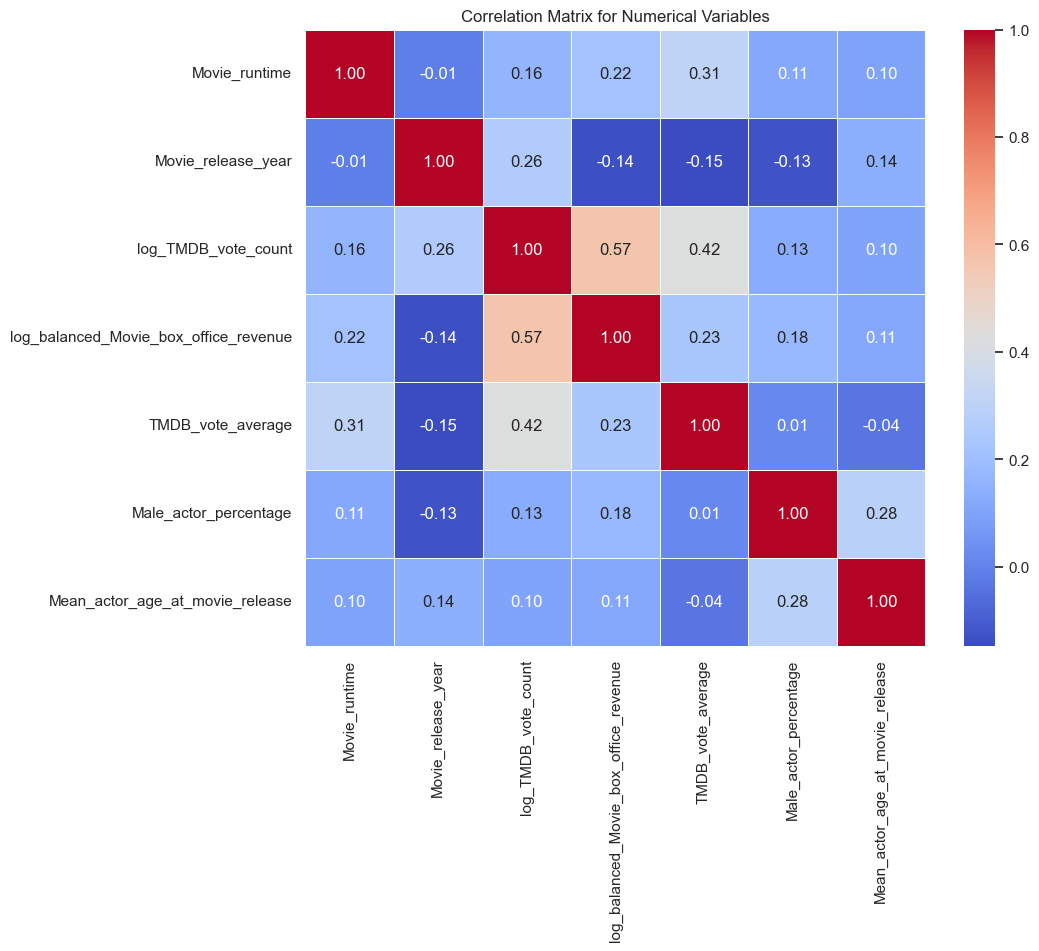

In [6]:
# Creating the correlation matrix
corr_matrix = movie_reg_data[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for Numerical Variables')
#plt.savefig(fname="plots/Correlation_matrix_numerical_variables.png", dpi=1000, bbox_inches='tight')
plt.show()

In [7]:
# Convert to list: ast.literal_eval("['Thriller', 'Horror']) will output the list ['Thriller', 'Horror']
categorical__toDummy_columns = ['Movie_countries', 'Movie_genres']

for column in categorical__toDummy_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))
    movie_reg_data.loc[:, column] = movie_reg_data[column].apply(lambda x: ast.literal_eval(x))

print(movie_reg_data[categorical__toDummy_columns])

['United States of America'] 
 <class 'str'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'str'>
                                        Movie_countries  \
0                            [United States of America]   
1                                      [United Kingdom]   
2                            [United States of America]   
3                            [United States of America]   
4               [United States of America, Netherlands]   
...                                                 ...   
7558  [Kingdom of Great Britain, Japan, England, Uni...   
7559                         [United States of America]   
7560                         [United States of America]   
7561                 [France, United States of America]   
7562                         [United States of America]   

                                           Movie_genres  
0     [Thriller, Science Fiction, Horror, Adventure,...  
1     [Costume d

In [8]:
# Check if converted to list
for column in categorical__toDummy_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))

['United States of America'] 
 <class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'list'>




Top 10 Movie_countries with the highest occurrences:
Drama: 3915 occurrences
Comedy: 2953 occurrences
Thriller: 2035 occurrences
Romance Film: 1785 occurrences
Action: 1741 occurrences
Action/Adventure: 1368 occurrences
Crime Fiction: 1260 occurrences
Adventure: 1115 occurrences
Indie: 966 occurrences
Horror: 832 occurrences


Top 10 Movie_genres with the highest occurrences:
United States of America: 6150 occurrences
United Kingdom: 963 occurrences
France: 516 occurrences
Germany: 468 occurrences
Canada: 310 occurrences
Japan: 211 occurrences
Italy: 184 occurrences
South Korea: 169 occurrences
Australia: 169 occurrences
Spain: 127 occurrences


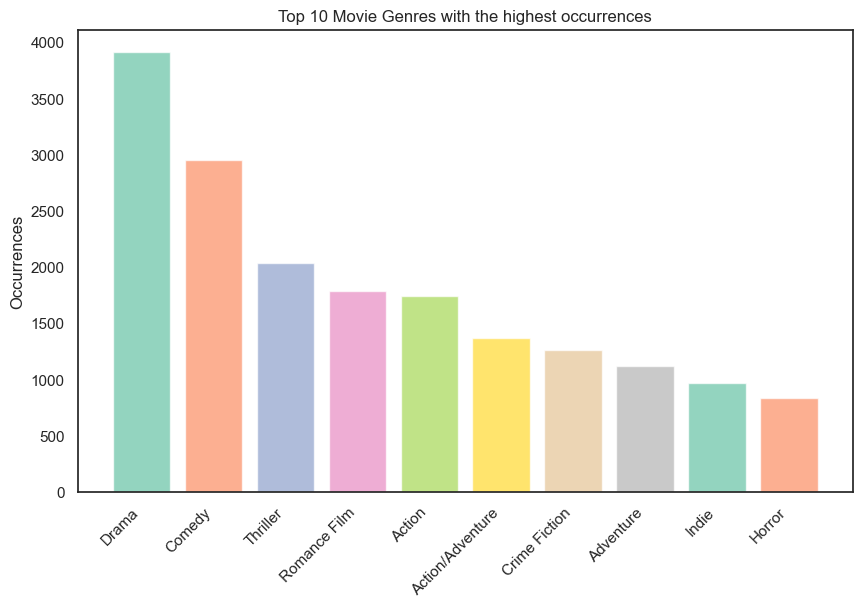

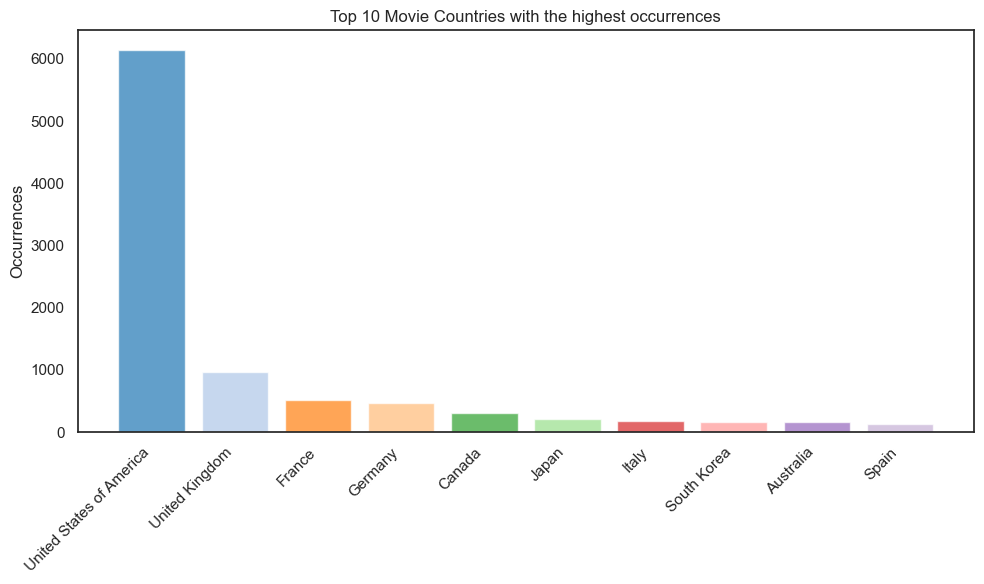

In [19]:
all_genres = {}
all_countries = {}

for col in categorical__toDummy_columns:
    for list_element in movie_reg_data[col]:
        # Iterate over each element in the list
        for element in list_element:
            # Increment the count for the element in the respective dictionary
            if col == 'Movie_countries':
                all_countries[element] = all_countries.get(element, 0) + 1
            elif col == 'Movie_genres':
                all_genres[element] = all_genres.get(element, 0) + 1

# Print the top N genres with the highest occurrences for each column
for occurrence_dict, column_name in zip([all_genres, all_countries], categorical__toDummy_columns):
    n = 10
    # Get the top N items with the highest occurrences (in descending order)
    top_n = sorted(occurrence_dict.items(), key=lambda x: x[1], reverse=True)[:n]

    print(f"\n\nTop {n} {column_name} with the highest occurrences:")
    for i, count in top_n:
        print(f"{i}: {count} occurrences")
        
# Colorblind-friendly palette
colors1 = plt.cm.Set2.colors  # A different colorblind-friendly palette for genres

# another colorblind-friendly palette
colors2 = plt.cm.tab20.colors  # This colormap provides distinct colors that are also colorblind-friendly

def plot_top_n_occurrences_colorful(data_dict, title, n=10, colors=colors):
    # Sort and select top N
    top_n = sorted(data_dict.items(), key=lambda x: x[1], reverse=True)[:n]
    labels, values = zip(*top_n)

    # Plotting
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values, align='center', alpha=0.7, color=colors[:n])
    plt.xticks(y_pos, labels, rotation=45, ha="right")
    plt.ylabel('Occurrences')
    plt.title(f'Top {n} {title} with the highest occurrences')

# Plot for genres with colorful bars
plot_top_n_occurrences_colorful(all_genres, 'Movie Genres', colors=colors1)
#plt.savefig(fname="plots/Genres_barplot.png", dpi=1000, bbox_inches='tight')

# Plot for countries with colorful bars
plot_top_n_occurrences_colorful(all_countries, 'Movie Countries', colors=colors2)
#plt.savefig(fname="plots/Countries_barplot.png", dpi=1000, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [10]:
formula_revenue = 'log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)'
formula_rating = 'TMDB_vote_average ~ C(TMDB_original_language)'

for col in numeric_columns:
    if col not in ['log_balanced_Movie_box_office_revenue','TMDB_vote_average']:
        formula_revenue += '+' + col
        formula_rating += '+' + col
print(formula_revenue, formula_rating)

log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release TMDB_vote_average ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release


In [11]:
# top n occurring elements in categorical columns
n = 10
print(movie_reg_data.shape)
for col in categorical__toDummy_columns:
    # Flatten the lists, handling NaN values
    flattened_values = [item for sublist in movie_reg_data[col].apply(lambda x: x if isinstance(x, list) else []).dropna() for item in sublist]

    # Count occurrences of each element
    element_counts = pd.Series(flattened_values).value_counts()

    # Select the top 10 most occurring elements
    top_elements = element_counts.head(n).index.tolist()

    # Create dummy variables only for the top 10 elements
    dummy_variables = pd.get_dummies(pd.Series(flattened_values).apply(lambda x: x if x in top_elements else 'Other'))

    # Rename the dummy columns to avoid conflicts
    dummy_variables.columns = dummy_variables.columns.str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')
    dummy_variables.columns = [f"{col}_{element}" for element in dummy_variables.columns]
    
    # Reset index before concatenation
    movie_reg_data = movie_reg_data.reset_index(drop=True)
    
    # Add dummy variables to the formula
    formula_revenue += ' + ' + ' + '.join(dummy_variables.columns)
    formula_rating += ' + ' + ' + '.join(dummy_variables.columns)
    
    # Merge the dummy variables with the original DataFrame
    movie_reg_data = pd.merge(movie_reg_data, dummy_variables, left_index=True, right_index=True)

print(formula_revenue,
     "\n\n", formula_rating, dummy_variables.shape, movie_reg_data.shape)

(7563, 10)
log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release + Movie_countries_Australia + Movie_countries_Canada + Movie_countries_France + Movie_countries_Germany + Movie_countries_Italy + Movie_countries_Japan + Movie_countries_Other + Movie_countries_South_Korea + Movie_countries_Spain + Movie_countries_United_Kingdom + Movie_countries_United_States_of_America + Movie_genres_Action + Movie_genres_Action_Adventure + Movie_genres_Adventure + Movie_genres_Comedy + Movie_genres_Crime_Fiction + Movie_genres_Drama + Movie_genres_Horror + Movie_genres_Indie + Movie_genres_Other + Movie_genres_Romance_Film + Movie_genres_Thriller 

 TMDB_vote_average ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release + Movie_countries_Australia + Movie_countries_Canada + Movie_countries_France + Movie_c

In [12]:
print(movie_reg_data.shape, movie_metadata.shape)

(7563, 32) (7563, 32)


In [13]:
# Setup models
model_revenue = smf.ols(formula=formula_revenue, data=movie_reg_data)
model_rating = smf.ols(formula=formula_rating, data=movie_reg_data)

In [14]:
np.random.seed(2)

# Fit the model
res_revenue = model_revenue.fit()
res_rating = model_rating.fit()

print(res_revenue.summary(),
      res_rating.summary())

                                      OLS Regression Results                                     
Dep. Variable:     log_balanced_Movie_box_office_revenue   R-squared:                       0.452
Model:                                               OLS   Adj. R-squared:                  0.447
Method:                                    Least Squares   F-statistic:                     101.4
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                                           16:43:16   Log-Likelihood:                -8186.9
No. Observations:                                   7563   AIC:                         1.650e+04
Df Residuals:                                       7501   BIC:                         1.693e+04
Df Model:                                             61                                         
Covariance Type:                               nonrobust                                         
                    

                                                  Coefficient        P-Value  \
C(TMDB_original_language)[T.da]                     -1.195834   4.352530e-03   
C(TMDB_original_language)[T.de]                     -1.006600   7.692703e-03   
C(TMDB_original_language)[T.el]                     -1.574803   1.146836e-02   
C(TMDB_original_language)[T.fa]                     -1.110633   1.653881e-02   
C(TMDB_original_language)[T.hu]                     -2.815765   6.044279e-06   
C(TMDB_original_language)[T.it]                     -0.741437   4.657398e-02   
C(TMDB_original_language)[T.no]                     -1.145790   2.399164e-02   
C(TMDB_original_language)[T.ro]                     -1.296678   3.710427e-02   
C(TMDB_original_language)[T.sr]                     -1.124275   4.036108e-02   
C(TMDB_original_language)[T.sv]                     -0.837140   3.984138e-02   
C(TMDB_original_language)[T.te]                     -2.400450   1.142379e-04   
Movie_countries_Australia[T.True]       

C:\Users\kavus\AppData\Local\Temp\ipykernel_17304\1544638491.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


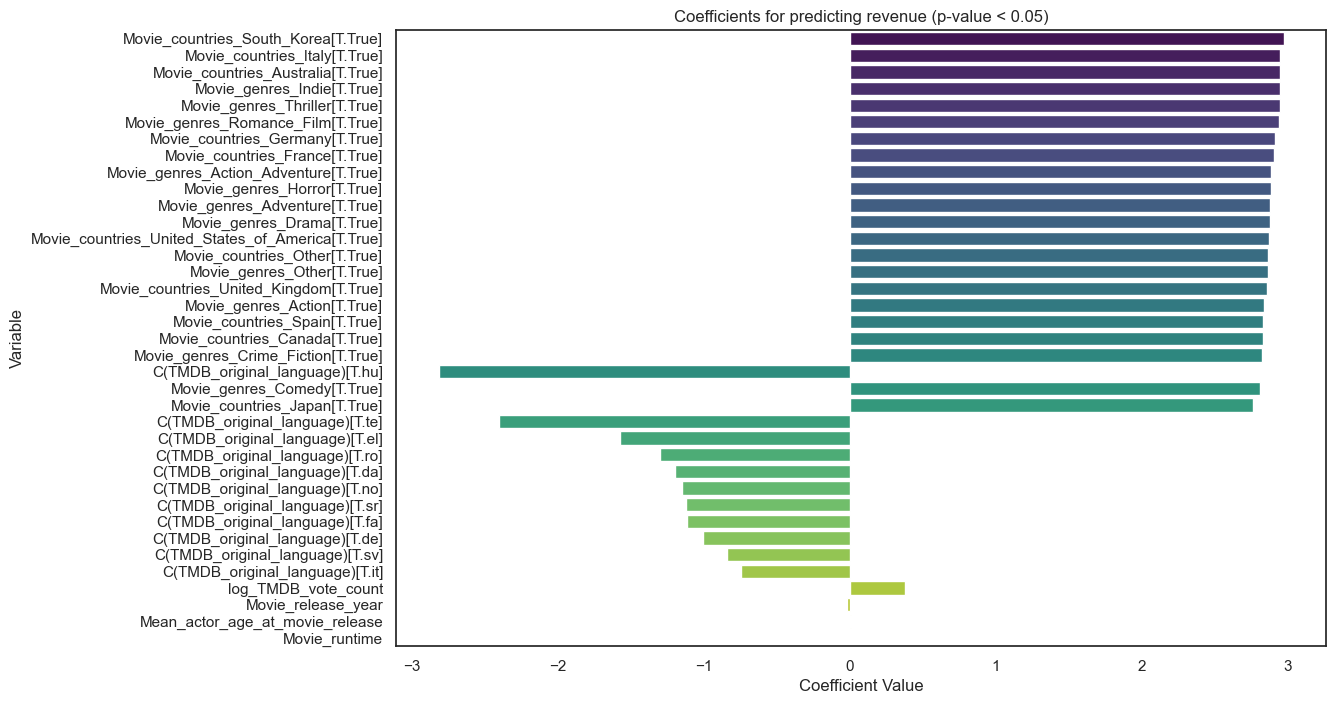

                                                  Coefficient        P-Value  \
C(TMDB_original_language)[T.en]                     -1.275148   6.162836e-05   
C(TMDB_original_language)[T.fr]                     -0.720367   2.510042e-02   
C(TMDB_original_language)[T.hi]                     -0.965824   3.199863e-03   
C(TMDB_original_language)[T.it]                     -0.845418   1.037155e-02   
C(TMDB_original_language)[T.ru]                     -0.923645   7.982949e-03   
C(TMDB_original_language)[T.tr]                     -1.205043   3.708601e-04   
Movie_countries_Australia[T.True]                    2.802579  1.350600e-184   
Movie_countries_Canada[T.True]                       2.866794  3.661066e-227   
Movie_countries_France[T.True]                       2.858784  3.690069e-252   
Movie_countries_Germany[T.True]                      2.823160  2.909945e-237   
Movie_countries_Italy[T.True]                        2.877162  9.324004e-208   
Movie_countries_Japan[T.True]           

C:\Users\kavus\AppData\Local\Temp\ipykernel_17304\1544638491.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


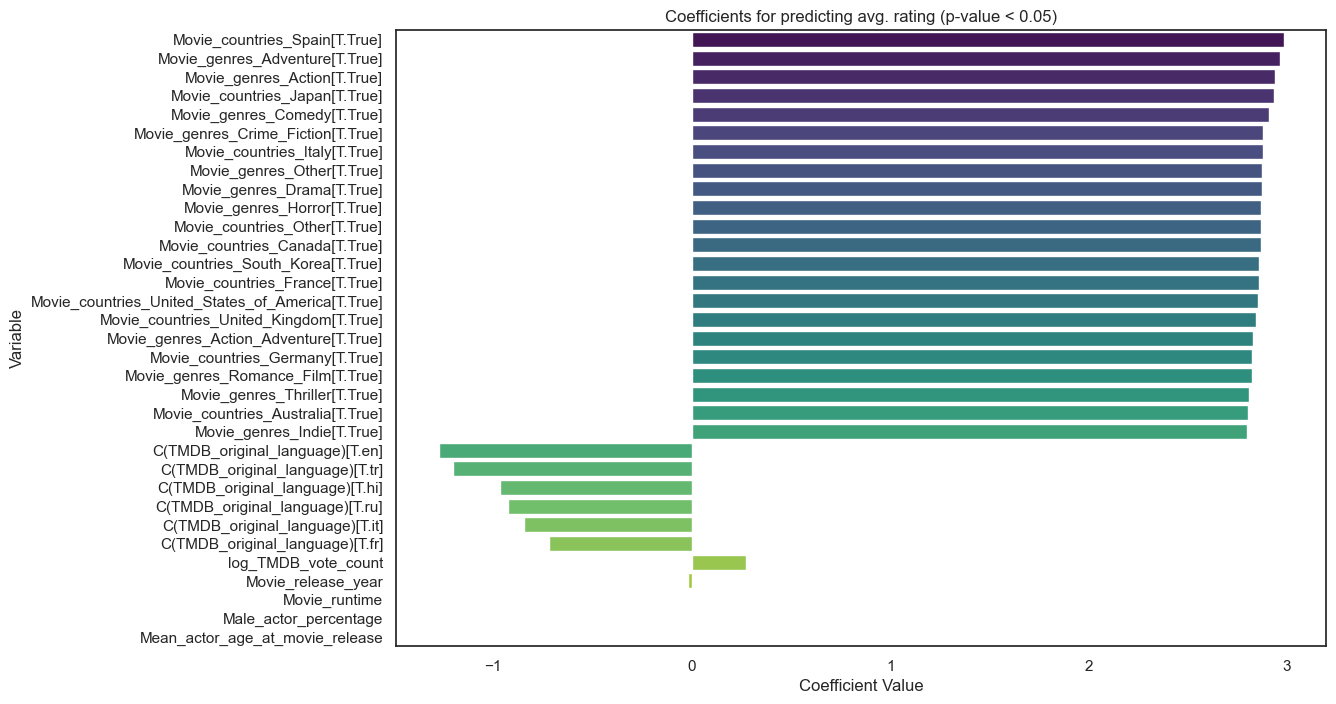

In [15]:
for res in [res_revenue, res_rating]:
# Extract
    coefficients = res.params
    p_values = res.pvalues
    coeff_names = coefficients.index

    # Create a DataFrame for better plotting
    coeff_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values, 'Name': coeff_names})

    # Exclude the intercept from the DataFrame
    coeff_df = coeff_df[coeff_df['Name'] != 'Intercept']

    # Filter coefficients with p-value < 0.05
    significant_coeff_df = coeff_df[coeff_df['P-Value'] < 0.05]
    print(significant_coeff_df)
    # Sort coefficients by magnitude for better visualization
    significant_coeff_df = significant_coeff_df.reindex(significant_coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

    # Plot significant coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variable')
    if res == res_revenue:
        plt.title('Coefficients for predicting revenue (p-value < 0.05)')
        #plt.savefig(fname="plots/Coefficients_revenue_model.png",dpi=1000, bbox_inches='tight')
    else:
        plt.title('Coefficients for predicting avg. rating (p-value < 0.05)')
        #plt.savefig(fname="plots/Coefficients_rating_model.png",dpi=1000, bbox_inches='tight')
    plt.show()

# Natural language processing

In this section we have attempted to process the summaries in a way that could cluster the movies depending on words used in the summaries themselves. 
Some of the processes take a long time to run so in the code there are multiple data sets or lists being saved as files to avoid running computational heavy tasks multiple times. 

In [54]:
# CHECK BEFORE RUNNING!!!
flag_preprocess = False # If false, skip the generation of a preprocessed corpus
flag_cluster_labels_kmeans = False # Run the kmeans algorithm and return labels for every movie 
flag_movie_cluster = False # If false, stop overwrite of a cluster matrix
flag_best_k = False # Runs a simulation to make silhouettes of a set number of k's for kmeans algorithm 
flag_best_component = False # Runs test to find a lower bound for amount of components
flag_reduced = False # Runs the TF/IDF compression 

### Load and filter movie data

In [7]:
# Read main data file 'movie_metadata_TMDB.csv'
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')

# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]


### Preprocess the summaries 

In [177]:
# Preprocess the summaries and stemming
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Apply stemming and lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    return ' '.join(words)


# Remove names form the summaries
nlp = spacy.load("en_core_web_sm")

def remove_names(text): 
    doc = nlp(text)
    filtered_text = []
    for token in doc:
        if token.ent_type_ != "PERSON":
            filtered_text.append(token.text)
    return " ".join(filtered_text)

In [178]:
# Preprocess the summaries 
preprocessed_summaries = []
if flag_preprocess:
    for summary in tqdm(filtered_summaries, desc="Processing summaries"):
        preprocessed_summaries.append(preprocess_text(remove_names(summary.split('\t')[1])))
    
    # Save preprocessed_summaries list to a file
    with open('nlp/preprocessed_summaries.pkl', 'wb') as file:
        pickle.dump(preprocessed_summaries, file)

In [179]:
# Combined stemmed summaries with labels 
if flag_preprocess:
    summaries_preprocessed_dist = []
    for i in range(len(preprocessed_summaries)):
        summaries_preprocessed_dist.append({"id": movie_ids[i], "text": preprocessed_summaries[i]})
    
    # Save summaries_preprocessed_dist to a file
    with open('nlp/summaries_preprocessed_dist.json', 'w') as f:
        json.dump(summaries_preprocessed_dist, f)

## TF/IDF vectorization & k-means

In [8]:
# Load preprocessed_summaries list from the saved file
with open('nlp/preprocessed_summaries.pkl', 'rb') as file:
    preprocessed_summaries = pickle.load(file)

In [9]:
# Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_summaries)

Now we will determine the optimal number of components (n_components) for dimensionality reduction using Truncated Singular Value Decomposition (Truncated SVD) by plotting the explained variance ratio against a range of specified values for n_components and identifying a point where a sufficient amount of variance is retained.

100%|██████████| 3/3 [12:04<00:00, 241.35s/it]


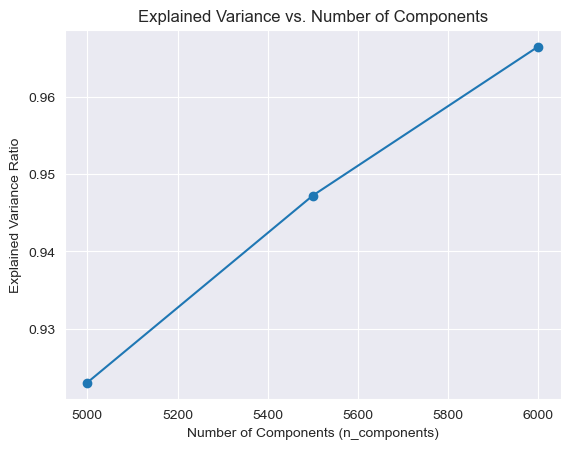

In [44]:
if flag_best_component:  
    # Specify a range of n_components to try
    components_range = np.arange(5000, 6001, 500)
    
    # List to store explained variance ratios
    explained_variances = []
    
    for n_components in tqdm(components_range):
        # Apply Truncated SVD
        svd = TruncatedSVD(n_components=n_components)
        tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
        
        # Calculate explained variance ratio
        explained_variance = np.sum(svd.explained_variance_ratio_)
        explained_variances.append(explained_variance)
    
    # Plot the explained variance ratio as a function of n_components
    plt.plot(components_range, explained_variances, marker='o')
    plt.title('Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

We see that with 6000 components we get above an EVR of 95%.

In [13]:
if flag_reduced:
    # Apply Truncated SVD for dimensionality reduction
    n_components = 6000  
    svd = TruncatedSVD(n_components=n_components)
    tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

### Finding the optimal k

In [45]:
if flag_best_k:
    silhouettes = []
    sse = []
    # Try multiple k
    for k in tqdm(range(20, 40)):
        # Cluster the data and assigne the labels
        labels = kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(tfidf_matrix_reduced) 
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(tfidf_matrix_reduced) 
        sse.append({"k": k, "sse": kmeans.inertia_})
        # Get the Silhouette score
        score = silhouette_score(tfidf_matrix_reduced, labels)
        silhouettes.append({"k": k, "score": score})

100%|██████████| 20/20 [12:02<00:00, 36.11s/it]


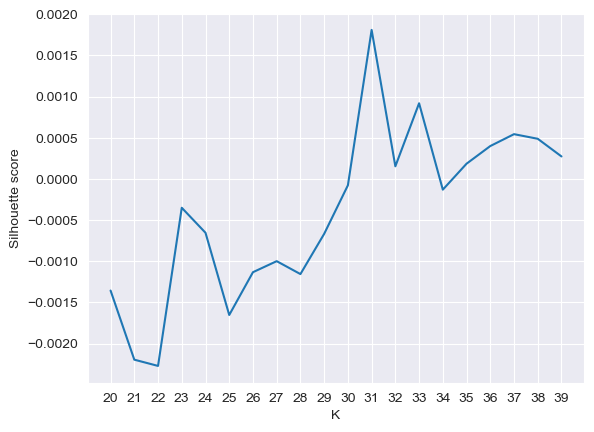

In [52]:
if flag_best_k:   
    silhouettes = pd.DataFrame(silhouettes)

    # Plot the data
    plt.plot(silhouettes['k'], silhouettes['score'])
    plt.xlabel("K")
    plt.ylabel("Silhouette score")
    
    # Set x-axis to only show whole numbers/integers
    plt.xticks(range(int(silhouettes['k'].min()), int(silhouettes['k'].max()) + 1))
    
    plt.show()

Negative values... Something is off. We have not been able to identify the problem for now.

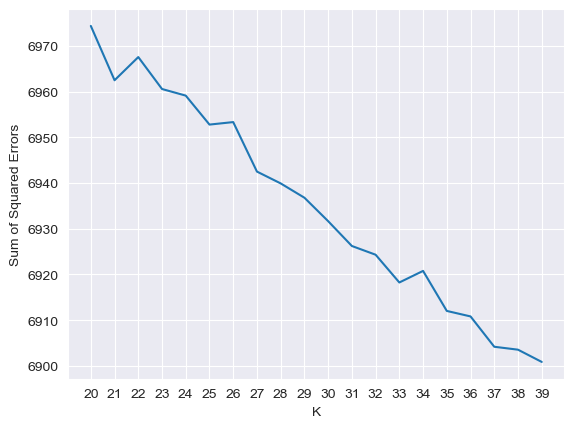

In [53]:
if flag_best_k:
    # Plot the data
    plt.plot(sse['k'], sse['sse'])
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
    # Set x-axis to only show whole numbers/integers
    plt.xticks(range(int(sse['k'].min()), int(sse['k'].max()) + 1))
    
    plt.show()

There is no obvious "elbow" to be seen. We choose to go with 30 clusters and see what we get.

### Apply K-means clustering 

In [31]:
# Apply KMeans clustering and return the labels for every movie 
num_clusters = 30 # k 

if flag_cluster_labels_kmeans: 
    cluster_labels = KMeans(n_clusters=num_clusters, n_init=20, random_state=3).fit_predict(tfidf_matrix_reduced) # This takes quite some time...
    # 10 is nice 
    # Save cluster_labels to a file
    with open('nlp/cluster_labels.pkl', 'wb') as f:
        pickle.dump(cluster_labels, f)


In [17]:
# Load cluster_labels from a file
with open('nlp/cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [18]:
# Create a dictionary to store movie IDs and their corresponding cluster labels
movie_clusters_id = dict(zip(movie_ids, cluster_labels))

With the movies given a cluster label we make a dataframe with all the movies in the given dataframe. For easy readability the movie ids are replaced with their actual name. 

In [42]:
# Create a DataFrame to store cluster information
cluster_df = pd.DataFrame(columns=[f'Cluster {i}' for i in range(num_clusters)])

# Iterate through movie clusters and match with movie_metadata
if flag_movie_cluster:
    for movie_id, cluster_label in tqdm(movie_clusters_id.items()):
        # Find the corresponding row in movie_metadata based on Wikipedia Movie ID
        movie_row = movie_metadata[movie_metadata['Wikipedia Movie ID'] == movie_id]
        
        # Extract movie name from the row
        movie_name = movie_row['Movie name'].values[0] if not movie_row.empty else f'Movie {movie_id}'
        
        # Update cluster_df with movie name in the appropriate cluster column
        cluster_df.loc[len(cluster_df), f'Cluster {cluster_label}'] = movie_name
    
    
    # Fill NaN values with empty string for better representation
    cluster_df.fillna('', inplace=True)

In [20]:
# Save cluster_df as CSV
if flag_movie_cluster:
    cluster_df.to_csv('nlp/clustered_movies.csv', index=True)

In [21]:
# Load cluster_df from a file
cluster_df = pd.read_csv('nlp/clustered_movies.csv')
cluster_df['Cluster 6'].sort_values().head(10)

1780                         11-11-11
684            A Month in the Country
5429                  Almost an Angel
2110                          Amadeus
6995    Amityville II: The Possession
723                 Angels and Demons
7051                        Bedazzled
735                    Ben and Arthur
931                   Beyond the Door
3991               Breaking the Waves
Name: Cluster 6, dtype: object

Looking at the titles in Cluster 6 as printed above, it looks as if our method at least clusters movies about similar topics.

## Visualizing word in clusters
In the following segment we try to look at the clusters and see if there seems to be any relevant information to be found in them. 
Firstly we will visualize the clusters in "Word Clouds".

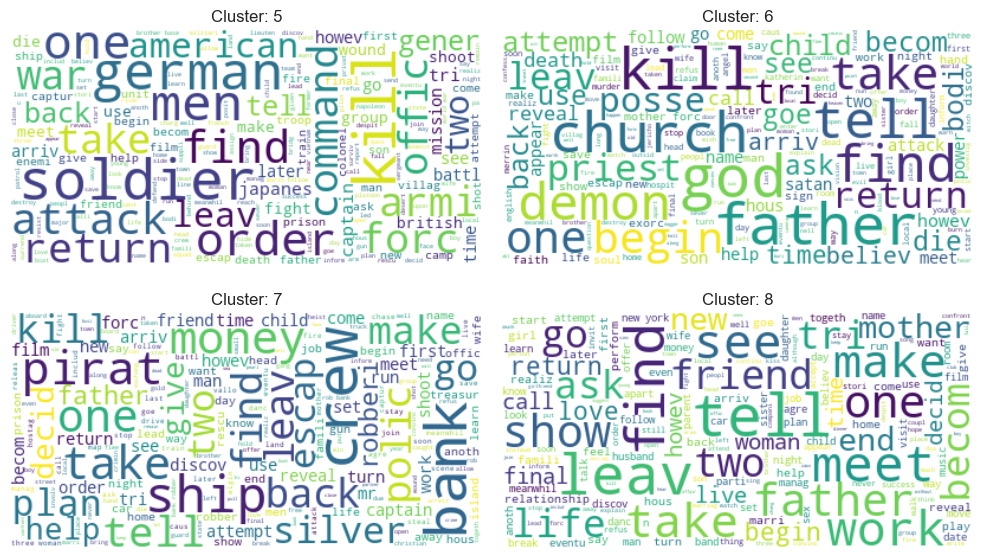

In [193]:

pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for k in range(5,9):
    ax = axes[(k-5) // 2, (k-5) % 2]

    # Extract data for the current cluster
    s = pic[pic.cluster == k]
    text = s['sum'].str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)

    # Plot the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title('Cluster: {}'.format(k))
    ax.axis("off")

# Adjust layout
plt.tight_layout()
#plt.savefig('figures/nlp/word_cloud_example', dpi=1000, bbox_inches='tight')
plt.show()

We see that the 4 cluster seen here have some clear tendencies as well. Looking at Cluster 6 the bigger words, that represent more relevance, seem to fal in the same category with alien, ship, kill and earth as dominant tokens. 

### Top words in each cluster
Now we will try to sort all the words after importance to the clusters.

In [23]:
def get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer, top_n=10):
    cluster_words = {}
    terms = vectorizer.get_feature_names_out()
    
    for cluster_label in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster_label)[0]
        cluster_tfidf_scores = np.sum(tfidf_matrix[cluster_indices], axis=0)
        sorted_indices = np.argsort(cluster_tfidf_scores)[0, ::-1][:top_n]
        top_words = [terms[i] for i in sorted_indices]
        cluster_words[cluster_label] = top_words
        
    return cluster_words

# Call the function to get cluster words
cluster_words = get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer)

In [24]:
cluster_words[6][0][0][:10]

array(['god', 'church', 'demon', 'priest', 'father', 'posse', 'exorc',
       'kill', 'faith', 'soul'], dtype=object)

We are again looking at Cluster 6. The most relevant words seem to relate a lot to the titles we saw falling into this cluster. Aliens and space are apparently a theme for this cluster. 

In [25]:
# Dataframe for top 1000 words ranked for every cluster
cluster_words_ranked = pd.DataFrame()

for i in range(len(cluster_words)):
    cluster_words_ranked[f'{i}'] = cluster_words[i][0][0][:1000]
    
cluster_words_ranked.head(10)

0       1         2             3       4         5       6        7  \
0     gang  vampir      babi          film    game   soldier     god     bank   
1    polic   blood     adopt          life    play       war  church     crew   
2     kill    kill     child         stori     win    german   demon    pirat   
3   member   lycan  pregnant          love  player      armi  priest  robberi   
4  brother   human    parent  relationship     get   japanes  father     ship   
5      get  coffin    mother         woman     one   command   posse   robber   
6    train    turn      girl          live  friend       men   exorc    money   
7      gun  attack      year         young    back      kill    kill      rob   
8   friend   night     coupl          year    team  american   faith      get   
9   leader    bite       son         becom    make      camp    soul    polic   

              8        9  ...            20          21       22        23  \
0          love     moor  ...          team        bond     town    murder   
1           get  campbel  ...          game       largo  sheriff      kill   
2           new      ren  ...         coach       agent     kill     polic   
3          tell     cole  ...        player        kill    small    killer   
4  relationship    gekko  ...          play       escap      men      case   
5        friend    flint  ...       footbal       zorin    cattl    detect   
6          leav  hetting  ...           win  scaramanga     gold     crime   
7         woman     danc  ...         leagu      soviet   deputi     offic   
8          meet  brenner  ...  championship     sanchez  brother  investig   
9          show    molli  ...     basketbal    submarin      man       man   

         24      25       26       27        28        29  
0     roman    drug    agent     jake    presid     zombi  
1     dewey  dealer      car     find     plane  umbrella  
2  ghostfac   polic    polic   alonzo    soviet      kill  
3    sidney    kill      fbi     take      bomb    wesker  
4    caesar  addict     kill     tell      kill    attack  
5      rome   money    money     luck     pilot  survivor  
6      kill  heroin    smith  brother      unit    reanim  
7    killer     get    offic      new     agent     escap  
8    murder    find  diamond     want    flight    bitten  
9     capot     one      cia    child  aircraft      viru  

[10 rows x 30 columns]

In [26]:
cluster_words_ranked.to_csv('nlp/cluster_words.csv', index=False, header=True)

We see that most clusters have themes that are easily identifiable. This makes sense as our method relies on clustering be similar words. 

## Rating & Box Office
In the following section we will try to explore whether there is a significant different in the rating of the different clusters.

In [27]:
# List with rating and movie ID for movies with more than 20 voters
movie_ratings_boxoffice_cleand = movie_metadata[['TMDB_vote_average', 'Wikipedia Movie ID','log balanced Movie box office revenue']]
movie_ratings_boxoffice_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)
movie_ratings_boxoffice_cleand

/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_43177/3791460451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_ratings_boxoffice_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)


Rating        ID  log balanced Movie box office revenue
0      5.123    975900                               5.998479
1      7.213    171005                               6.013946
2      7.571     77856                               7.618825
3      7.157    156558                               6.320091
4      5.656  25960460                               2.679255
...      ...       ...                                    ...
7558   6.597   1191380                               5.229038
7559   6.867     54540                               7.487860
7560   4.881   7761830                               6.170883
7561   6.327   1918494                               5.705871
7562   5.700    664006                               6.300011

[7563 rows x 3 columns]

### Balancing the data

In [33]:
# Create a DataFrame from the dictionary
movie_id_clusters_df = pd.DataFrame({'ID': movie_ids,'Cluster_Label': cluster_labels})

In [34]:

# Merge movie_clusters_df with movie_ratings_cleand on the 'id' column
movie_id_clusters_rating_boxoffice_df = pd.merge(movie_id_clusters_df, movie_ratings_boxoffice_cleand, on='ID')
movie_id_clusters_rating_boxoffice_df.head(10)

ID  Cluster_Label  Rating  log balanced Movie box office revenue
0  31186339             14   7.195                               7.576113
1  20663735             14   7.500                               4.563201
2   2231378              8   6.700                               6.047861
3    595909             23   6.700                               5.866737
4   1952976             14   5.630                               6.504127
5  18188932              2   6.800                               5.256392
6   1480747              4   5.148                               6.254840
7    447194             14   6.600                               6.764931
8  12978934             13   6.444                               6.327801
9   8471210             18   7.457                               5.423761

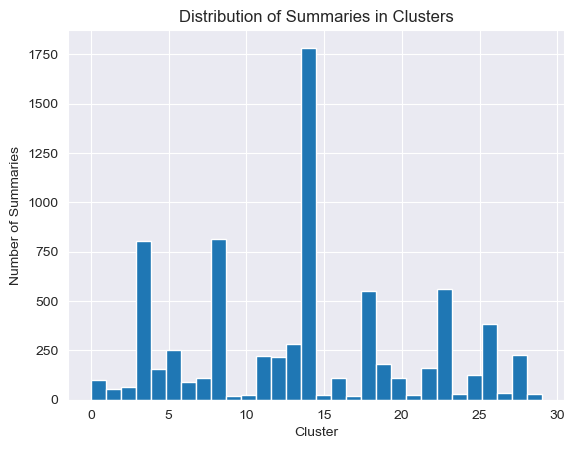

In [35]:
# Visualize the distribution of clusters
plt.hist(movie_id_clusters_rating_boxoffice_df['Cluster_Label'], bins=num_clusters, align='mid', rwidth=1)
plt.xlabel('Cluster')
plt.ylabel('Number of Summaries')
plt.title('Distribution of Summaries in Clusters')
plt.show()

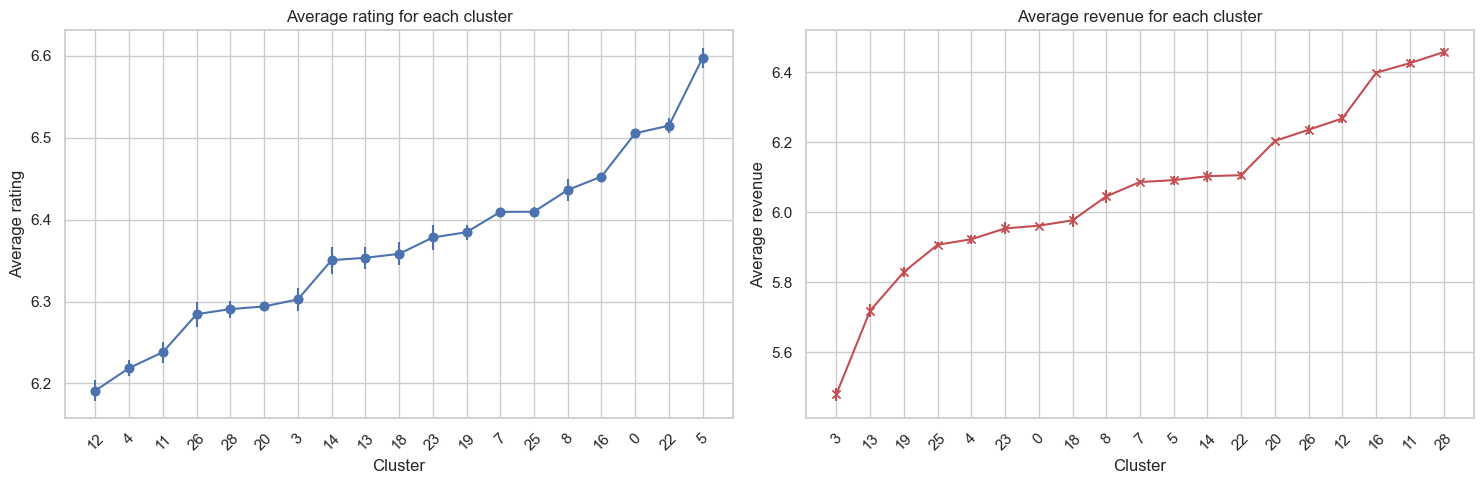

In [202]:
# Initialize a DataFrame to store the sampled data
sampled_means = pd.DataFrame()

#samplesize
sample_size = 100

for cluster in movie_id_clusters_rating_boxoffice_df['Cluster_Label'].unique():
    cluster_data = movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]
    
    if len(cluster_data) >= sample_size:
        means_list = []

        for _ in range(100):
            sample = cluster_data.sample(n=sample_size)
            means = sample[['Rating', 'log balanced Movie box office revenue']].mean()
            means_list.append(means)

        means_df = pd.DataFrame(means_list)
        cluster_means = means_df.mean()
        cluster_se = means_df.std() / np.sqrt(len(means_df))
        confidence_interval = 1.96 * cluster_se

        cluster_summary = pd.DataFrame({'Cluster': [cluster], 
                                        'Mean Rating': [cluster_means['Rating']], 
                                        'Rating CI': [confidence_interval['Rating']],
                                        'Mean Revenue': [cluster_means['log balanced Movie box office revenue']],
                                        'Revenue CI': [confidence_interval['log balanced Movie box office revenue']]})
        sampled_means = pd.concat([sampled_means, cluster_summary], ignore_index=True)

# Sort by mean rating and get order of clusters
sorted_indices_rating = sampled_means['Mean Rating'].sort_values().index
sorted_clusters_rating = sampled_means.loc[sorted_indices_rating, 'Cluster']

# Sort by mean revenue and get order of clusters
sorted_indices_revenue = sampled_means['Mean Revenue'].sort_values().index
sorted_clusters_revenue = sampled_means.loc[sorted_indices_revenue, 'Cluster']

# Set Seaborn style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot for mean rating
axes[0].plot(range(len(sorted_clusters_rating)), sampled_means.loc[sorted_indices_rating, 'Mean Rating'], 'bo-', label='Mean Rating')
axes[0].errorbar(range(len(sorted_clusters_rating)), sampled_means.loc[sorted_indices_rating, 'Mean Rating'], yerr=sampled_means.loc[sorted_indices_rating, 'Rating CI'], fmt='o', color='b')
axes[0].set_xticks(range(len(sorted_clusters_rating)))
axes[0].set_xticklabels(sorted_clusters_rating, rotation=45)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average rating')
axes[0].set_title('Average rating for each cluster')

# Plot for mean revenue
axes[1].plot(range(len(sorted_clusters_revenue)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], 'rx-', label='Mean Revenue')
axes[1].errorbar(range(len(sorted_clusters_revenue)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], yerr=sampled_means.loc[sorted_indices_revenue, 'Revenue CI'], fmt='x', color='r')
axes[1].set_xticks(range(len(sorted_clusters_revenue)))
axes[1].set_xticklabels(sorted_clusters_revenue, rotation=45)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average revenue')
axes[1].set_title('Average revenue for each cluster')

plt.tight_layout()
#plt.savefig('figures/nlp/nlp_rev_rating_subplots', dpi=1000, bbox_inches='tight')
plt.show()

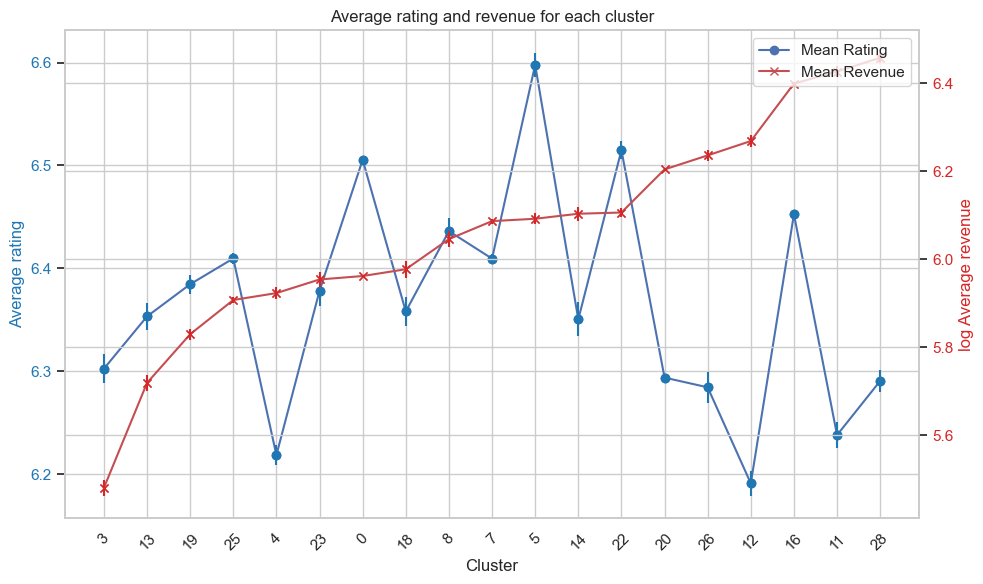

In [203]:

# Sort by mean revenue
sorted_indices_revenue = sampled_means['Mean Revenue'].sort_values().index
sorted_clusters = sampled_means.loc[sorted_indices_revenue, 'Cluster']

# Create a single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting mean rating
color = 'tab:blue'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average rating', color=color)
ax1.plot(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Rating'], 'bo-', label='Mean Rating')
ax1.errorbar(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Rating'], yerr=sampled_means.loc[sorted_indices_revenue, 'Rating CI'], fmt='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a twin Y-axis for mean revenue
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('log Average revenue', color=color)
ax2.plot(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], 'rx-', label='Mean Revenue')
ax2.errorbar(range(len(sorted_clusters)), sampled_means.loc[sorted_indices_revenue, 'Mean Revenue'], yerr=sampled_means.loc[sorted_indices_revenue, 'Revenue CI'], fmt='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set the x-axis ticks
ax1.set_xticks(range(len(sorted_clusters)))
ax1.set_xticklabels(sorted_clusters, rotation=45)

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

plt.legend(lines, labels, loc='upper right')
plt.title('Average rating and revenue for each cluster')
plt.savefig('figures/nlp/nlp_rev_rating_both_plots', dpi=1000, bbox_inches='tight')
fig.tight_layout() 
plt.show()

In [204]:
# We need to create a list of ratings and revenues for each cluster to perform ANOVA
clusters = movie_id_clusters_rating_boxoffice_df['Cluster_Label'].unique()
rating_lists = [movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]['Rating'].values for cluster in clusters]
revenue_lists = [movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]['log balanced Movie box office revenue'].values for cluster in clusters]

# Perform ANOVA for Ratings
f_val_rating, p_val_rating = f_oneway(*rating_lists)
print(f'ANOVA test for Ratings: F-value = {f_val_rating}, p-value = {p_val_rating}')

# Perform ANOVA for Revenues
f_val_revenue, p_val_revenue = f_oneway(*revenue_lists)
print(f'ANOVA test for Revenues: F-value = {f_val_revenue}, p-value = {p_val_revenue}')

ANOVA test for Ratings: F-value = 3.8100025195399536, p-value = 2.4183296196784113e-11
ANOVA test for Revenues: F-value = 18.943516163245764, p-value = 1.0912945073999776e-93


The ANOVA results indicate that there are significant differences in mean revenues and ratings across the clusters.

In [40]:
# World-cloud plotting function
pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

def plot_worldcloud(clusters):
    count = 0
    for k in clusters:
        
        ax = axes[count]
        
        # Extract data for the current cluster
        s = pic[pic.cluster == k]
        text = s['sum'].str.cat(sep=' ')
        
        # Generate word cloud
        wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
        
        # Plot the word cloud
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Cluster: {}'.format(k))
        ax.axis("off")
        
        count += 1

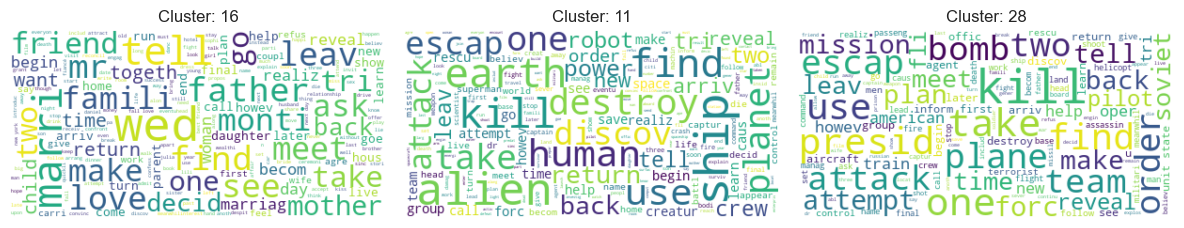

In [205]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([16,11,28])

# Adjust layout
plt.tight_layout()
plt.show()

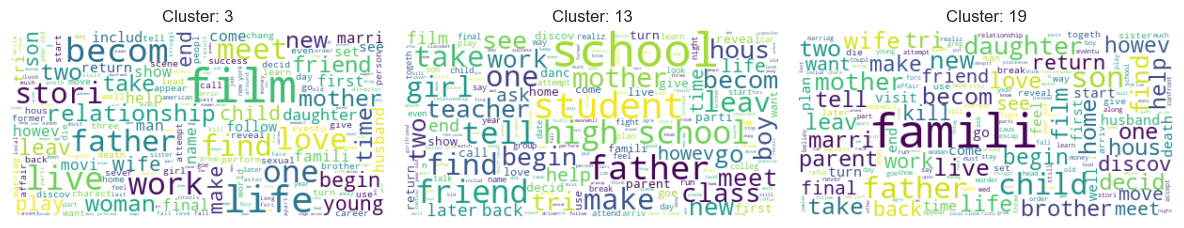

In [206]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([3,13,19])
# Adjust layout
plt.tight_layout()
plt.show()

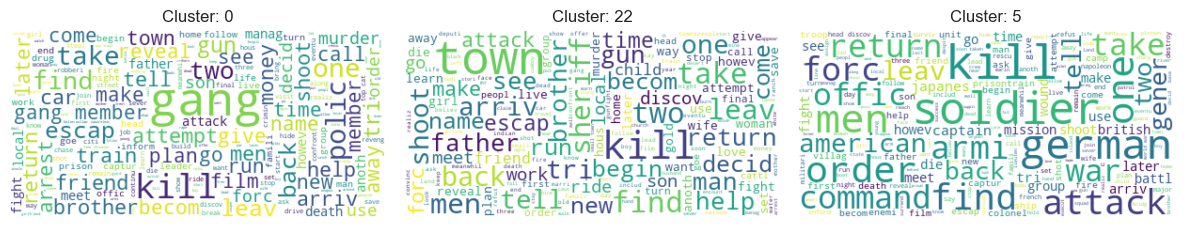

In [207]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([0,22,5])
# Adjust layout
plt.tight_layout()
plt.show()

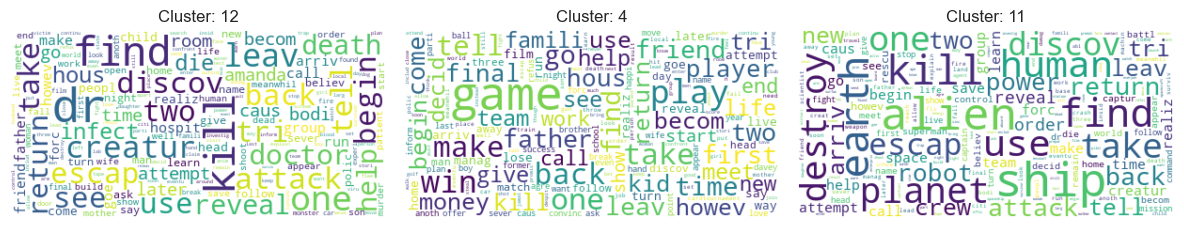

In [208]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([12,4,11])
# Adjust layout
plt.tight_layout()
plt.show()

The plot and linear regression indicates, that there is a significant decline in box office revenue, as the percentage of female characters increases.

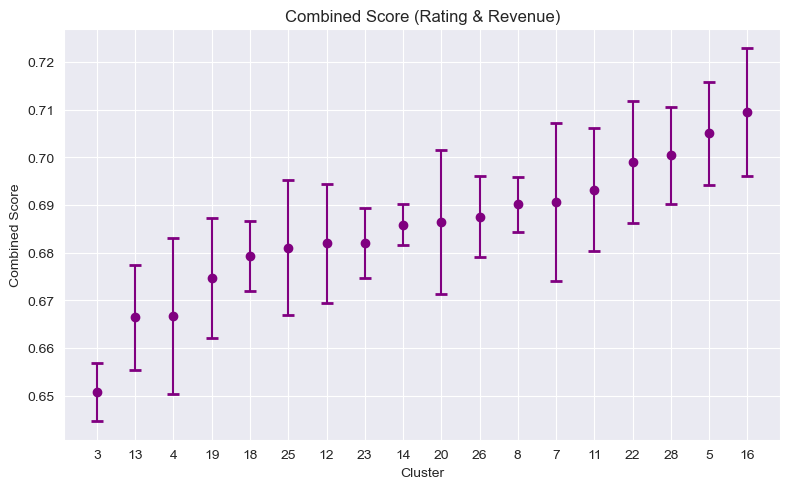

In [36]:
# Normalize the 'Rating' and 'log balanced Movie box office revenue' columns
scaler = MinMaxScaler()
movie_id_clusters_rating_boxoffice_df[['Normalized Rating', 'Normalized Revenue']] = scaler.fit_transform(
    movie_id_clusters_rating_boxoffice_df[['Rating', 'log balanced Movie box office revenue']])

# Calculate the combined score
movie_id_clusters_rating_boxoffice_df['Combined Score'] = movie_id_clusters_rating_boxoffice_df[['Normalized Rating', 'Normalized Revenue']].mean(axis=1)

# Group by cluster and calculate mean combined score and standard error for each cluster
cluster_stats = movie_id_clusters_rating_boxoffice_df.groupby('Cluster_Label').agg({
    'Combined Score': ['mean', 'size', 'std']
}).reset_index()

# Filter clusters with more than 100 movies
cluster_stats = cluster_stats[cluster_stats[('Combined Score', 'size')] > 100]

# Calculate the standard error of the mean (SEM)
cluster_stats['SEM'] = cluster_stats[('Combined Score', 'std')] / np.sqrt(cluster_stats[('Combined Score', 'size')])

# Calculate the 95% confidence intervals
z_score = stats.norm.ppf(0.975)  # 2-tailed z-score for 95% confidence
cluster_stats['CI'] = z_score * cluster_stats['SEM']

# Sort the clusters by the combined score mean
cluster_stats_sorted = cluster_stats.sort_values(by=('Combined Score', 'mean'))

# Flatten the multi-level columns
cluster_stats_sorted.columns = [' '.join(col).strip() for col in cluster_stats_sorted.columns.values]

# Extract the sorted cluster labels
sorted_order = cluster_stats_sorted['Cluster_Label'].tolist()

# Now we plot the points with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(range(len(sorted_order)), cluster_stats_sorted['Combined Score mean'], 
             yerr=cluster_stats_sorted['CI'], fmt='o', color='purple', ecolor='purple', capsize=4, capthick=2)

# Adjust the x-axis to show the cluster labels
plt.xticks(range(len(sorted_order)), sorted_order)

plt.xlabel('Cluster')
plt.ylabel('Combined Score')
plt.title('Combined Score (Rating & Revenue)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Perform ANOVA using scipy.stats f_oneway function
anova_results = stats.f_oneway(*(movie_id_clusters_rating_boxoffice_df[movie_id_clusters_rating_boxoffice_df['Cluster_Label'] == cluster]['Combined Score'] for cluster in movie_id_clusters_rating_boxoffice_df['Cluster_Label'].unique()))

print(f"ANOVA F-statistic: {anova_results.statistic}, p-value: {anova_results.pvalue}")

ANOVA F-statistic: 7.810783560928443, p-value: 6.264345308530011e-32


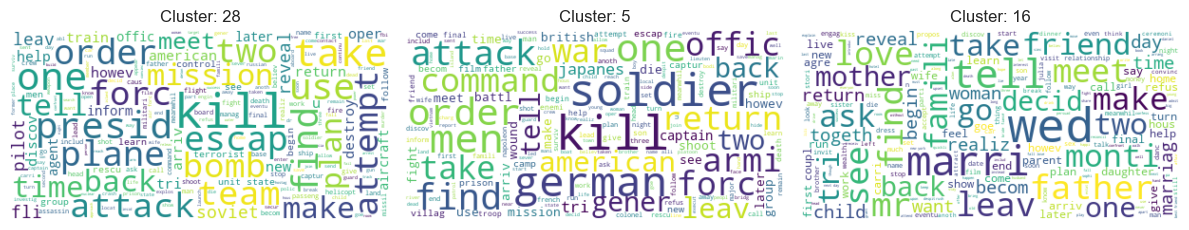

In [41]:
# Create a figure with 1x3 subplots (1 row and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_worldcloud([28,5,16])
# Adjust layout
plt.tight_layout()
plt.show()